# Сегментация покупателей интернет-магазина "Пока все еще тут"

Для показа визуализаций Plotly рекомендовано открывать проект по ссылке: https://colab.research.google.com/drive/1EtGh1wSTXf09bEH84hXCgALlcnQwPQAu?usp=sharing 

**Описание проекта** 

Интернет-магазин товаров для дома «Пока все ещё тут» пытается стать лучше. Собственник планирует увеличить выручку путем возврата клиентов за повторными покупками на сайт через тематические товарные рассылки. От аналитика требуется выявить профили покупателей. «Пока все ещё тут» — мы создаём уют!

**Цель**

Подготовить рекомендации для собственника бизнеса по целесообразности проведения маркетинговых рассылок с персонализированными товарными предложениями в разрезе сегментов покупателей

**Задачи**

- предобработка данных:
  - загрузка данных, оценка общей информации о датасете - количество строк, наличие пропусков, типы данных,
  - преобразовать тип данных при необходимости,
  - проверить наличие явных и неявных дубликатов, удалить при необходимости,
- исследовательский анализ данных:
  - определение валового объема выручки и среднего чека по месяцам года в целом по компании
  - оценить давность совершенных покупок каждым пользователем, выделение клиентских сегментов по давности покупок (Recency)
  - рассчитать количество заказов на пользователя в течение исследуемого периода, выделение клиентских сегментов по количеству совершенных покупок (Frequency)
  - средний чек заказа на пользователя в течение исследуемого периода, выделение клиентских сегментов (Monetary)
  - изучение товарных категорий по объему продаж в натуральном и денежном выражении, определение сезонного спроса внутри категорий
- проверка гипотез:
  - подбор метода для проверки гипотез
  - существование статистической значимости между сегментами покупателей, выделенными на этапе исследовательского анализа данных: *наличие или отсутствие различий внутри клиентских выборок относительно среднего чека покупки*;  *наличие или отсутствие различий внутри клиентских выборок относительно давности покупки*
- подготовка презентации:
  - составление плана презентации
  - оформление

**Исходные данные**

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Предобработка данных

### Загрузка данных и общая информация

In [6]:
import pandas as pd
import datetime
from datetime import datetime
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import date
import scipy
import seaborn as sns
from scipy import stats as st
import io
import plotly.io as pio
pio.renderers.default = 'colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import files
 
 
uploaded = files.upload()

Saving ecommerce_dataset.csv to ecommerce_dataset (2).csv


In [8]:
#Загружаем данные 
df = pd.read_csv(io.BytesIO(uploaded['ecommerce_dataset.csv']))
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [9]:
#Смотрим инфо о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В датасете 6737 строк, пропусков нет, тип данных для `date` и `order_id` требует корректировки. Названия столбцов в змеином стиле, все ок.

### Изменение типов данных

In [10]:
# Преобразуем дату к формату даты, а идентификатор заказа к строке
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['order_id'] = df['order_id'].astype('str')

In [11]:
#Оценим, за какой период наши данные
df=df.sort_values(by='date')

print('Датасет содержит данные с', df['date'].min(), 'по', df['date'].max())

Датасет содержит данные с 2018-10-01 00:00:00 по 2019-10-31 16:00:00


### Работа с дубликатами

In [12]:
#Проверка явных дублей
df.duplicated().sum()

0

Явных дублей нет

In [13]:
#Посмотрим, сколько уникальных заказов в базе
df['order_id'].nunique()

2784

В базе транзакций присутствует информация о 2,7 тыс. заказов при том, что в датасете более 6,5 тыс. строк. Почему на один заказ может быть несколько строк, если датасет заявлен как выгрузка по транзакциям:
- оплата в рассрочку
- возврат товара
- просто баг выгрузки?
Попробуем посмотреть на один из заказов, чтобы понять причину

In [14]:
df['order_id'].unique()

array(['68477', '68478', '68479', ..., '73158', '73162', '73164'],
      dtype=object)

In [15]:
df.query('order_id == "68477"')

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0


Все проще - в заказе просто несколько товаров Немного странно, что они идут разными транзакциями, т.к. один заказ, как правило, одна транзакция... Для выяления неявных дубликатов проверим дубли по сочетанию id заказа, пользователя и наименования товара. Теоретически в заказе пользователя могло меняться количество и цена. Их тоже нужно добавить в оценку дублей

In [16]:
df['quantity'] = df['quantity'].astype('str')
df['price'] = df['price'].astype('str')
(df['customer_id']+df['order_id']+df['product']+df['quantity']+df['price']).nunique()

4873

Итого у нас 4,8 тыс. неповторяющихся заказов. А остальное тогда что? Внимательнее изучим дубликаты

In [17]:
df['a'] = df['order_id']+df['product']+df['quantity']+df['price']+df['customer_id']
df['b']=df['a'].duplicated()
df.query('b == True')

,date,customer_id,order_id,product,quantity,price,a,b
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0,68522Эвкалипт Гунни d-17 см h-60 см11409.032de...,True
...,...,...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,70960Сумка-тележка 2-х колесная Gimi Argo крас...,True
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0,73108Мирт d-9 см h-15 см1134.0cb65d08a-dae7-48...,True
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,73136Таз пластмассовый со стиральной доской (И...,True
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,73136Таз пластмассовый со стиральной доской (И...,True


1.8 тыс. строк потенциальных дубликатов, имеющих разное время. Рассмотрим один из таких размноженных во времени заказов.

In [18]:
df.query('order_id == "68474"')

,date,customer_id,order_id,product,quantity,price,a,b
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,False
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,68474Доска гладильная Eurogold Professional 13...,True


Имеет место ситуация при которой на одно и то же сочетание клиента, заказа, товара, цены и количества приходится несколько строк с разной датой и временем. Мы знаем, что данные в выгрузку грузились из разных источников, что и могло вызвать размножение строк. В любом случае такие дубликаты картину исказят. Предполагаю, что их нужно удалить. 1,8 тыс. записей. 27% датасета `О_о `

Чтобы удалить лишнее корректно, примем для себя, что первая запись по тому или иному дубликату - это сформированный клиентом заказ - он первичен сам по себе. Соответственно все последующие записи уже вторичны и, возможно, отражают движение заказа внутри бизнес-процесса (например, собран, отгружен, доставлен и т.д.). Соответственно в базе должна остаться только первая запись, а все оставльные - удалим. Ранее мы уже сортировали данные по возрастанию даты, поэтому мы можем сразу дропнуть лишнее.

In [19]:
df = df.query('b == False')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4873 non-null   datetime64[ns]
 1   customer_id  4873 non-null   object        
 2   order_id     4873 non-null   object        
 3   product      4873 non-null   object        
 4   quantity     4873 non-null   object        
 5   price        4873 non-null   object        
 6   a            4873 non-null   object        
 7   b            4873 non-null   bool          
dtypes: bool(1), datetime64[ns](1), object(6)
memory usage: 309.3+ KB


Нужно вернуть обратно типы данных на количество и цену, а также удалить лишние технические столбцы, чтобы не засорять датасет.

In [20]:
df['quantity'] = df['quantity'].astype('int')
df['price'] = df['price'].astype('float')
df = df.drop(columns=['a', 'b']) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4873 non-null   datetime64[ns]
 1   customer_id  4873 non-null   object        
 2   order_id     4873 non-null   object        
 3   product      4873 non-null   object        
 4   quantity     4873 non-null   int64         
 5   price        4873 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 266.5+ KB


<ipython-input-20-b37518d679eb>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-b37518d679eb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Та как мы имеем дело с выгрузкой со стороны клиента, которая собиралась из различных источников, проверим, что на один уникальный заказ приходится один клиентский id. Иными словами, что у одного заказа - только один заказчик.

In [21]:
#Составим сводник из заказов с несколькими покупателями
dubble_orders = df.pivot_table(index='order_id', values = 'customer_id', aggfunc = 'nunique')\
.reset_index()\
.sort_values(by = 'customer_id', ascending = False)\
.query('customer_id >1')
dubble_orders

,order_id,customer_id
2610,72845,4
1914,71480,3
902,69485,3
817,69310,2
1066,69833,2
2576,72790,2
2569,72778,2
248,14872,2
1939,71542,2
1712,71054,2


Видно, что в нашем распоряжении "кривая" выгрузка - в ней нескольким десяткам уникальных заказов соответствуют по несколько разных заказчиков... Посмотрим, что это за заказы на примере первого - где целых 4 разных клиента

In [22]:
df.query('order_id == "72845"')

,date,customer_id,order_id,product,quantity,price
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


Клиенты разные, время разное. ID заказа и товар одинаковый. "Атаку клонов" придется подчищать. Т.к. мы не можем доподлинно установить, кто является реальным заказчиком, удалим все такие заказы - в своднике визуально видно, что их не очень много - до 30 шт.

In [23]:
#список id заказов, которые нужно удалить
a = dubble_orders['order_id'].to_list()
#чистим датасет
df = df.query('order_id not in @a')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 6735
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4807 non-null   datetime64[ns]
 1   customer_id  4807 non-null   object        
 2   order_id     4807 non-null   object        
 3   product      4807 non-null   object        
 4   quantity     4807 non-null   int64         
 5   price        4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 262.9+ KB


Таким образом, мы избавились от явных "артефактов" в данных - очистили заказы с несколькими заказчиками, а также убрали неявные дубликаты в строках, которые размножились из-за нескольких источников выгрузки. Теперь можно приступать к исследовательскому анализу. А заказчику стоит дать рекомендацию о корректном сборе и хранении информации о заказах, чтобы в дальнейшем избегать "шумов" и аномалий.

## Исследовательский анализ

### Выручка и средний чек

Оценим взглядом собственника, как идут дела в  интернет-магазине. Оценим валовую выручку и средний чек заказа по месяцам года.

In [24]:
#Добавим в датасет информацию о стоимости каждой строки
df['revenue'] = df['price'] * df['quantity']
#Укоротим дату до месяца и года
df['month'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

In [25]:
#Составим сводную таблицу выручки по месяцам для дальнейшей визуализации
revenue = df.pivot_table(index = 'month', values = 'revenue', aggfunc = 'sum').reset_index()
revenue

,month,revenue
0,2018-10,351162.0
1,2018-11,359348.0
2,2018-12,346449.0
3,2019-01,230336.0
4,2019-02,305242.0
5,2019-03,252188.0
6,2019-04,316469.0
7,2019-05,238294.0
8,2019-06,903176.0
9,2019-07,235410.0


In [26]:
#Построим визуализацию
fig = px.bar(revenue, x='month', y='revenue', title="Общая выручка по месяцам", text='revenue')
fig.update_traces(textfont_size=12, textposition="outside")
fig.show()

Выручка в июyе сильно выбивается из общей массы. Возможно мы имеем дело с выбросами данных. Попробуем идентифицировать выброс

In [27]:
df.query('month == "2019-06"').pivot_table(index = 'order_id', values = 'revenue', aggfunc = 'sum').reset_index().sort_values(by='revenue', ascending = False).head()

,order_id,revenue
120,71743,675000.0
83,71668,49432.0
48,71598,11400.0
93,71685,8832.0
86,71674,7004.0


А вот и аномалия - один заказ на 675 тыс. как раз перекашивает всю июньскую выручку. Посмотрим, что в нем.

In [28]:
df.query('order_id == "71743"')

,date,customer_id,order_id,product,quantity,price,revenue,month
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06


Тысяча вантузов `О_о`
Проверим покупателя - может мы имеем дело с оптовиком и он все время берет крупные партии.


In [29]:
df.query('customer_id == "312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6"')

,date,customer_id,order_id,product,quantity,price,revenue,month
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06


Очевидно, что данный заказ является выбросом. Удалим его и еще раз визуализируем данные по месячной выручке.

In [30]:
#Фильтруем аномалию
df = df.query('order_id != "71743"')
#Строим сводник
revenue_new = df.pivot_table(index = 'month', values = 'revenue', aggfunc = 'sum').reset_index()
#Визуализируем
fig = px.bar(revenue_new, x='month', y='revenue', title="Общая выручка по месяцам без аномалий", text='revenue')
fig.update_traces(textfont_size=12, textposition="outside")
fig.show()

К сожалению, в нашем распоряжении данные за короткий промежуток времени: чуть больше года. Но даже этого времени достаточно, чтобы увидеть, что выручка в октябре 2019 упала почти на 50% по отношению к выручке октября 2018. Не удивительно, что собственник ставит перед собой цель увеличения оборота.

Теперь изучим, как менялось количество заказов по месяцам.

In [31]:
reserv = df.pivot_table(index = 'month', values = 'order_id', aggfunc = 'count').reset_index()
fig = px.bar(reserv, x='month', y='order_id', title="Количество заказов по месяцам", text='order_id')
fig.update_traces(textfont_size=12, textposition="outside")
fig.show()

Вероятнее всего на графике мы видим отражение сезонности бизнеса, а точнее - товаров, которые бизнес транслирует в рынок. Т.к. явные всплески активности приходятся на апрель и май, а всплеска в объемах выручки не происходит, можно предположить, что клиенты в это время массово начинают закупать дешевый товар и делают небольшие по сумме заказы в большом количестве. С учетом товарного характера интернет-магазина могу предположить, что это могут быть какие-нибудь семена для дачников. 

А теперь можно проанализировать средний чек заказа - возможно он также покажет некие особенности.

In [32]:
#Объеденим таблицы, посчитанные ранее
avg_check = pd.merge(revenue_new, reserv, how ='inner', on ='month')
#Переименуем столбцы
avg_check=avg_check.rename(columns ={'revenue': 'income', 'order_id': 'count_order'})
#Вычислим средний чек за месяц
avg_check['avg'] = round((avg_check['income'])/(avg_check['count_order']))
fig = px.bar(avg_check, x='month', y='avg', title="Динамика среднего чека", text='avg')
fig.update_traces(textfont_size=12, textposition="outside")
fig.show()

При оценке среднего чека также заметен сезонный фактор - дорогие заказы в декабре и январе - их мало, но они генерят максимальные значения по выручке. И дешевые заказы в апреле-мае, генерируют сопоставимую со среднегодовой выручку, но за счет большого количества самих заказов роняют средний чек. Если исключить два сезонных периода, видно, что в целом средний чек находится примерно на одном уровне - около 850 руб. Было бы интересно узнать, каков средний чек в аналогичной нише е-ком у конкурентов и на сколько 850 руб. соответствует среднему по отрасли.

Для презентации составим отдельный график, который совмещал бы в себе объемы выручки и средний чек.

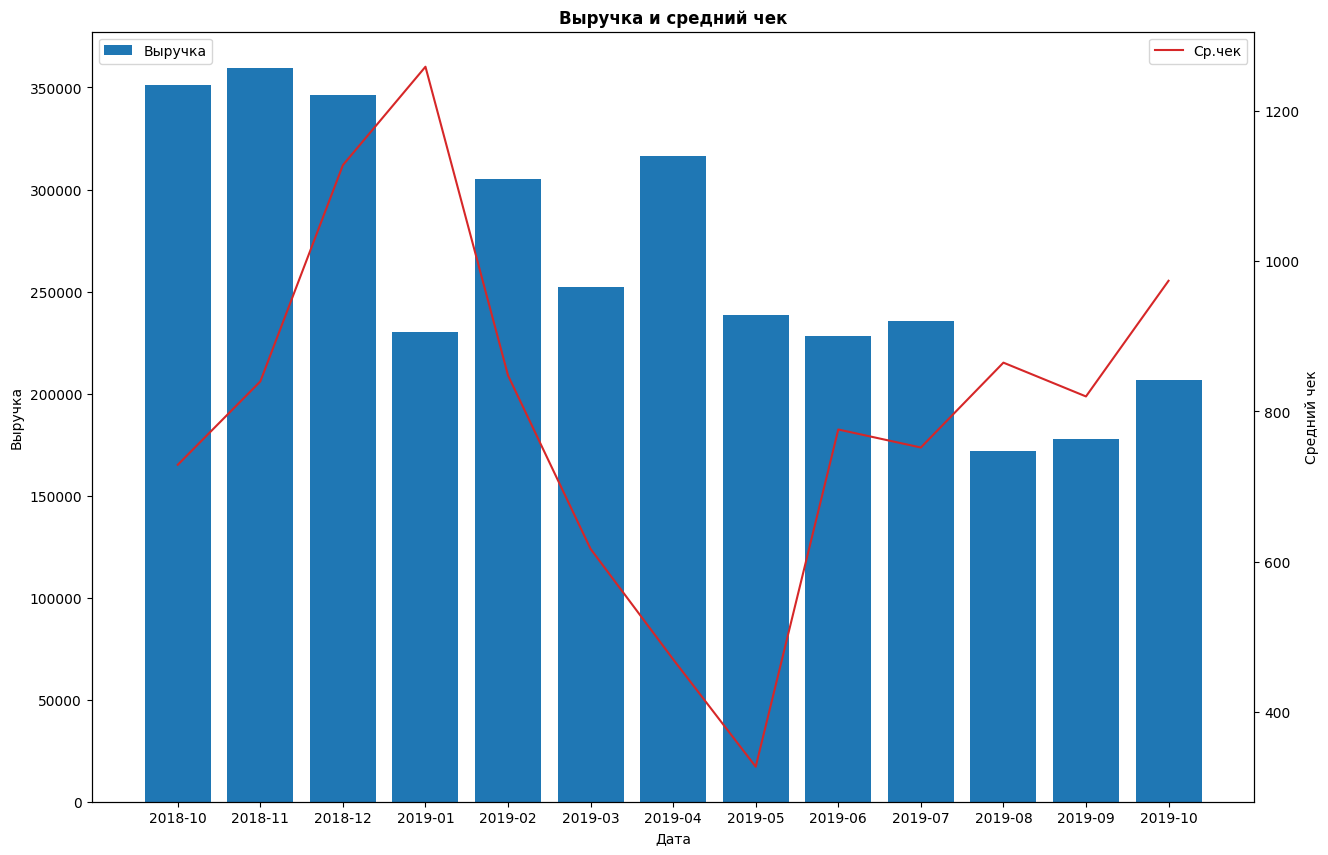

In [33]:
# Строим столбчатую диаграмму с выручкой
fig, ax1 = plt.subplots(figsize=(15,10))
 
ax1.set_xlabel('Дата')
ax1.set_ylabel('Выручка')
ax1.bar(avg_check['month'], avg_check['income'], label='Выручка')
ax1.legend(['Выручка'], loc='upper left')
 
# Строим линейную диаграмму со средним чеком
ax2 = ax1.twinx()
 
color = 'tab:red'
ax2.set_ylabel('Средний чек')
ax2.plot(avg_check['month'], avg_check['avg'], color = color)
ax2.tick_params(axis ='y')
ax2.legend(['Ср.чек'])

plt.title('Выручка и средний чек', fontweight ="bold")
plt.show()

### RFM-анализ: частота покупок

Оценим количество пользователей, которые сделали несколько покупок за исследуемый промежуток времени.

In [34]:
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10


In [35]:
loyal_customers = df.pivot_table(index = 'customer_id', values = 'order_id', aggfunc = 'nunique')\
.reset_index()\
.rename(columns = {'order_id': 'count_orders'})\
.sort_values(by='count_orders', ascending = False)\
.query('count_orders > 1')
loyal_customers

,customer_id,count_orders
1869,c971fb21-d54c-4134-938f-16b62ee86d3b,126
726,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1073,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1705,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
16,0184f535-b60a-4914-a982-231e3f615206,5
...,...,...
1694,b6da6f7a-d2a3-424a-878e-1876c8b88126,2
1136,7aefdb9a-5d54-411f-8bc2-91f454b6c7d9,2
1232,85dc0459-129e-4c97-83c8-5c1cdff65aff,2
1230,859ff7b8-ec8c-4d6b-8c38-345788d8766f,2


В выгрузке есть клиент, который чуть больше, чем за год, совершил 126 заказов. Чтобы сделать такое количество заказов, нужно покупать примерно раз в 3 дня в масштабе нашей выгрузки. Посмотрим на заказы этого клиента, чтобы удостовериться, что мы имем дело с обычным покупателем, а не с оптовиком или каким-нибудь багом выгрузки.

In [36]:
#Узнаем ширину товарной номенклатуры
df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['product'].nunique()

130

В 126 заказах было 130 уникальных товаров. Иными словами - клиент редко заказывает одно и то же - это почти всегда разный ассортимент. 

Далее, чтобы удостовериться, что мы не имеем дело с оптовиком, оценим глубину товарной номенклатуры

In [37]:
#Посмотрим, какие количества присутствовали в заказах
df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['quantity'].unique()

array([ 1, 10, 64,  5,  4,  3,  2, 12, 13,  6])

''

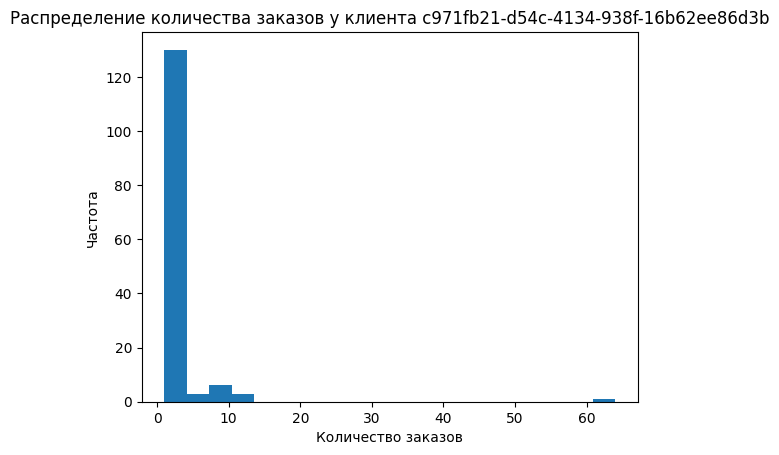

In [38]:
#Визуализируем распределение количества заказанных товаров у данного клиента
df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['quantity']\
.plot(kind = 'hist', bins = 20, title = 'Распределение количества заказов у клиента c971fb21-d54c-4134-938f-16b62ee86d3b')
plt.xlabel('Количество заказов')
plt.ylabel('Частота', rotation=90)
;

In [39]:
#Посмотрим на товар, который наш "золотой" клиент заказал 64 раза
df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b" and quantity == 64')

,date,customer_id,order_id,product,quantity,price,revenue,month
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0,1216.0,2018-10


Глубина и ширина номенклатуры рассматриваемого клиента указывает на том, что он - самый обычный покупатель. Просто очень лояльный. Он делает заказы довольно часто - в среднем раз в три дня - каждый раз заказывая новый ассортимент. Заказываемое количество товаров не указывает на оптовую принадлежность клиента, т.к. преимущественно идет заказ на 1 штуку одного наименования, а 64 заказанных оконных стяжки вполне себе могут вписаться в логику стандартного потребления.

Далее оценим, каков процент лояльных покупателей - которые сделали заказ чаще одного раза за исследуемый период.

In [40]:
#Посчитаем конверсию в повторную покупку
len(loyal_customers)/len(df)

0.032251352476071575

Конверсия в повторную покупку составила около 10%. Много это или мало - необходимо сравнивать со средними значениями по отрасли. Но тот факт, что 90% клиентов не вернулись в течение года уже говорит о том, что "теплую" уже совершившую первый заказ аудиторию, никто далее не прорабатывает - это непозволительная роскошь для коммерции. Соответственно лояльные возвращающиеся клиенты в "Пока все еще тут" - это скорее исключение, чем правило. Соответственно рекомендация для собственника - будить своих "спящих" клиентов, уже знакомых с магазином. 

Теперь произведем разбивку на кластеры в следующей логике:
- 1 - частые покупки;
- 2 - редкие покупки;
- 3 - разовые покупки.

С разовыми покупками все ясно - на них придется 90% датасета. А вот чтобы определиться, что считать частыми и редкими - построим гистаграмму по ранее полученному своднику `loyal_customers`

''

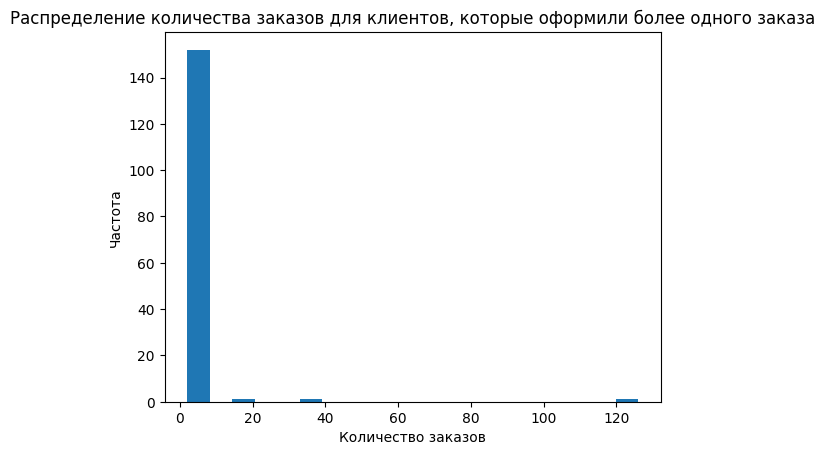

In [41]:
loyal_customers['count_orders']\
.plot(kind = 'hist', bins = 20, title = 'Распределение количества заказов для клиентов, которые оформили более одного заказа')
plt.xlabel('Количество заказов')
plt.ylabel('Частота', rotation=90)
;

Судя по гистограмме можно сказать, что к редким покупкам в разрезе наших данных мы отнесем клиентов с количеством заказов до 10. А к частым покупкам отнесем количество заказов более 10.

Проведем сегментацию.

In [42]:
#Составим сводную таблицу с id-покупателя и количеством заказов
count_purchase = df.pivot_table(index = 'customer_id', values = 'order_id', aggfunc = 'nunique').reset_index()
count_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393 entries, 0 to 2392
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  2393 non-null   object
 1   order_id     2393 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.5+ KB


In [43]:
#Напишем функцию для сегментации
def segment_frequency(a): 
    if a == 1:
        return '3'
    if a <= 10:
        return '2'
    if a > 10:
        return '1'

#Создадим столбец с сегментом клиента, приенив функцию
count_purchase['segment_frequency']=count_purchase['order_id'].apply(segment_frequency)
count_purchase=count_purchase.rename(columns = {'order_id':'count_orders'})
count_purchase

,customer_id,count_orders,segment_frequency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,3
1,001cee7f-0b29-4716-b202-0042213ab038,1,3
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,3
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,3
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,3
...,...,...,...
2388,ff601403-b094-4b86-9ac6-264d725b9277,1,3
2389,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,3
2390,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,3
2391,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,3


In [44]:
#Перенесем информацию из сводника о количестве заказов и сегменте по каждому пользователю в основной датасет
df = pd.merge(df, count_purchase, how ='inner', on ='customer_id')
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,month,count_orders,segment_frequency
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10,1,3
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10,1,3
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10,1,3
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10,1,3
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10,1,3


''

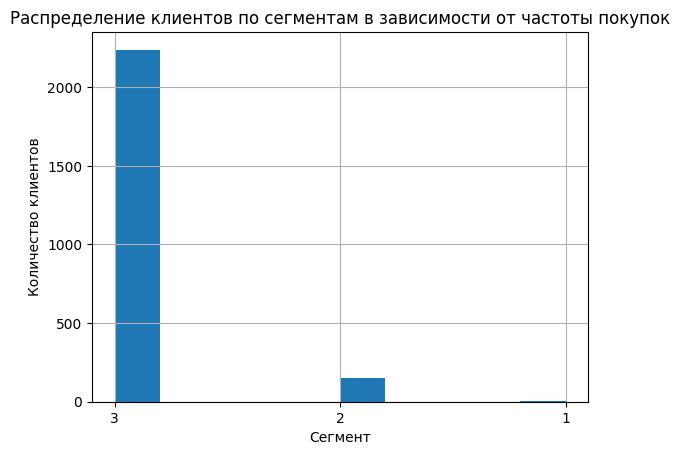

In [45]:
#Визуализируем распределение по сегментам
count_purchase['segment_frequency'].hist()
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов', rotation=90)
plt.title('Распределение клиентов по сегментам в зависимости от частоты покупок')
;

In [46]:
#Узнаем, сколько польззователей в каждом сегменте
count_purchase.pivot_table(index = 'segment_frequency', values = 'customer_id', aggfunc = 'count')

,customer_id
segment_frequency,
1,3
2,152
3,2238


Таким образом мы сегментировали всех пользователей на 3 группы:
1 - частые покупки;
2 - редкие покупки;
3 - разовые покупки.
93% пользователей относятся к сегменту, совершающим разовые покупки. Около 6% покупают раз в 1-2 месяца. Клиенты с более частыми покупками - скорее единичные аномалии. Таким образом собственнику необходимо приложить максимум усилий, чтобы выяснить причины отказов - почему пользователи не возвращаются повторно? Не устраивает ассортимент? Плохая доставка? Неудобный сайт? Проведя работу над ошибками необходимо заняться возвратом отвалившейся клиентской базы.

### RFM-анализ: давность покупок

Для оценки давности покупки каждого клиента и его дальнейшей сегментации в соответствии с RFM-анализом, добавим расчетный столбец в датасет, где будет указано время, прошедшее с момента совершения покупки клиентом до момента окончания выгрузки.

In [47]:
#Время между покупкой и концом выгрузки
df['final_buy'] = (df['date'].max() - df['date']).dt.round('1D')
#На основании датасета создадим таблицу, содержащую уникальные номера заказов 
#и интервал времени между заказом и концом выгрузки
time_interval = df.drop_duplicates (subset='order_id')
time_interval = time_interval.sort_values(by= 'date')
#Т.к. у нас есть клиенты, которые совершили несколько заказов, нужно очистить временную таблицу от дубликатов 
#в столбце с id-клиента, оставив только последний заказ
time_interval = time_interval.drop_duplicates (subset='customer_id', keep = 'last')
#Чтобы определиться с диапазонами разбивки, изучим характеристики данных
time_interval['final_buy'].describe()

count                           2393
mean     204 days 03:58:17.701629754
std      111 days 06:33:34.896309124
min                  0 days 00:00:00
25%                109 days 00:00:00
50%                212 days 00:00:00
75%                295 days 00:00:00
max                396 days 00:00:00
Name: final_buy, dtype: object

В выгрузке есть заказы, совершенные непосредственно в день выгрузки (минимальное значение временного интервала = 0). Максимальный период между заказо и концом выгрузки - 396 дней, то есть есть клиенты, которые совершили 1 заказ за все рассматриваемое время - в первый день выгрузки. Видно, что 75-й квартиль составляет 295 дней, то есть 75% клиентов сделали свой последний заказ чуть больше 9 месяцев назад и 25% клиентов сделали свой последний заказ в течение последних 3 месяцев. 

Проведем сегментацию. Примем, что:
- 1 - недавно заказавшие - клиенты, совершившие свой последний заказ менее 109 дней назад;
- 2 - спящие - клиенты, совершившие свой последний заказ менее 295 дней назад;
- 3 - давно заказавшие - клиенты, совершившие заказ более 295 дней назад.

In [48]:
#Приведем инттервал времени к числовому значению для удобства дальнейшей работы
time_interval['a'] = time_interval['final_buy'].astype('str')
time_interval['a'] = time_interval['a'].str.split(' ').apply(lambda x: x[0])
time_interval['a'] = time_interval['a'].astype('int')

In [49]:
#Напишем функцию для сегментации
def segment_recency(b): 
    if b <= 109:
        return '1'
    if b <= 295:
        return '2'
    if b > 295:
        return '3'

#Создадим столбец с сегментом клиента, прмиенив функцию
time_interval['segment_recency']=time_interval['a'].apply(segment_recency)


''

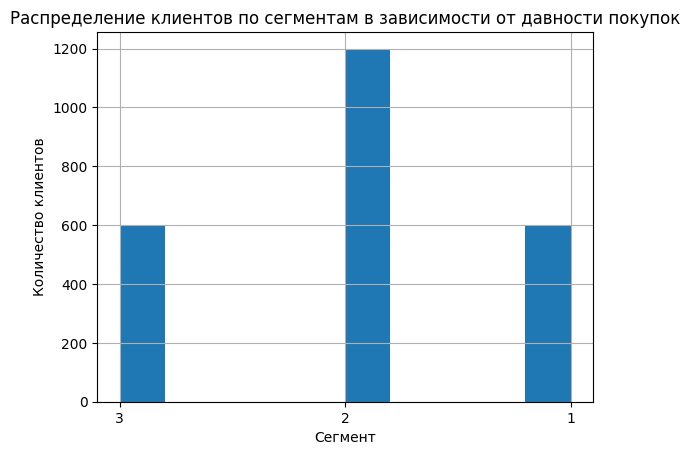

In [50]:
#Визуализируем распределение по сегментам
time_interval['segment_recency'].hist()
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов', rotation=90)
plt.title('Распределение клиентов по сегментам в зависимости от давности покупок')
;

In [51]:
#Узнаем, сколько пользователей в каждом сегменте
time_interval.pivot_table(index = 'segment_recency', values = 'customer_id', aggfunc = 'count')

,customer_id
segment_recency,
1,600
2,1196
3,597


Таким образом, мы сегментировали пользователей на: 1 - недавно заказавших; 2 - спящих; 3 - давно заказавших.
Получается, что количество пользовавтелей, сделавших последний заказ в последние 3 месяца примерно равно количеству пользователей, сделавших последний заказ более 9 месяцев назад от конца выгрузки. Обе эти категории составляют 50% от всего количества пользователей. Остальные 50% относятся к "спящим" пользователям - они сделали последний заказ в интервале между 3-мя и 9-ю месяцами по отношению к концу выгрузки. Вероятнее всего, основной акцент для рассылки следует сделать на "спящих" пользователях - потенциально эта категория еще может вернуться на сайт за покупками, плюс она самая многочисленная.

In [52]:
#Перенесем информацию из временной таблицы о давности заказов и сегменте по каждому пользователю в основной датасет
df = pd.merge(df, time_interval[['customer_id','final_buy', 'segment_recency', 'a']], how ='left', on ='customer_id')
df=df.rename(columns={'final_buy_x':'between_buy_and_end', 'final_buy_y':'between_lastbuy_and_end'})

### RFM-анализ: средний чек

Для сегментации пользователей по среднему чеку покупки, необходимо определить выручку по каждому заказу, найти количество заказов на пользователя и определить средний чек на пользователя.

In [53]:
#Составим сводную таблицу с общими суммами за заказ
total_by_order = df.pivot_table(index = 'order_id', values = 'revenue', aggfunc = 'sum')\
.reset_index()\
.rename(columns={'revenue':'sum_by_order'}).sort_values(by = 'sum_by_order', ascending = False)
total_by_order

,order_id,sum_by_order
1984,71668,49432.0
1057,69830,47385.0
720,69156,33680.0
910,69504,32718.0
567,68878,24370.0
...,...,...
1177,70093,22.0
1919,71546,22.0
1979,71661,15.0
632,68985,15.0


In [54]:
#Присоединим сводник к основному датасету
df = pd.merge(df, total_by_order, how ='left', on ='order_id')
df

,date,customer_id,order_id,product,quantity,price,revenue,month,count_orders,segment_frequency,between_buy_and_end,between_lastbuy_and_end,segment_recency,a,sum_by_order
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10,1,3,396 days,396 days,3,396,1037.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10,1,3,396 days,396 days,3,396,1037.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10,1,3,396 days,396 days,3,396,1037.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10,1,3,396 days,396 days,3,396,1037.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10,1,3,396 days,396 days,3,396,1037.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4801,2019-10-30 21:00:00,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,314.0,2019-10,1,3,1 days,1 days,1,1,314.0
4802,2019-10-31 09:00:00,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,112.0,2019-10,1,3,0 days,0 days,1,0,112.0
4803,2019-10-31 11:00:00,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,2019-10,1,3,0 days,0 days,1,0,329.0
4804,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,2019-10,1,3,0 days,0 days,1,0,1087.0


In [55]:
#Составим сводник по среднему чеку заказа на пользваотеля
mean_check = df.pivot_table(index = 'customer_id', values = 'sum_by_order', aggfunc = 'mean').reset_index().drop_duplicates().rename(columns={'sum_by_order':'mean_check'})
mean_check.sort_values(by = 'mean_check', ascending = False).head(10)

,customer_id,mean_check
194,146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
1328,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,33680.0
967,6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0
819,58a4c3cc-504f-43ea-a74a-bae19e665552,26616.0
262,1b2764ad-9151-4051-a46a-9b01b62e6335,24370.0
1470,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,22056.0
1335,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,16536.0
853,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,15300.0
131,0d87f4ae-465a-4fac-81e6-5d629761783e,14917.0
989,6be74251-7159-4cc0-99fb-d034a17c61b0,11250.0


In [56]:
#Изучим, каково распределение нашего среднего чека
mean_check['mean_check'].describe()

count     2393.000000
mean      1236.305505
std       2165.373675
min         14.000000
25%        298.000000
50%        676.000000
75%       1471.000000
max      49432.000000
Name: mean_check, dtype: float64

Видно, что средний чек колеблется в диапазоне от 14 до 49 432 руб. за заказ. 25% покупателей за исследуемый период сделали заказы со средним чеком до 298 руб. 75% покупателей уложились в 1471 руб. в среднем за заказ. Округлим эти значения и разобьем пользователей на кластеры, где:
- 1 - пользователь с высоким средним чеком - выше 1500 руб.;
- 2 - пользователь со средним чеком - от 300 до 1500 руб.;
- 3 - пользователи с низким чеком - до 300 руб.

In [57]:
#Напишем функцию для сегментации
def segment_monetary(c): 
    if c <= 300:
        return '3'
    if c <= 1500:
        return '2'
    if c > 1500:
        return '1'


In [58]:
#Создадим столбец с сегментом клиента, прмиенив функцию
mean_check['segment_monetary']=mean_check['mean_check'].apply(segment_monetary)
mean_check

,customer_id,mean_check,segment_monetary
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,2
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,2
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1
...,...,...,...
2388,ff601403-b094-4b86-9ac6-264d725b9277,1649.0,1
2389,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,397.0,2
2390,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,389.0,2
2391,ffb80538-3fda-4351-8ea9-9d2bec58bb07,974.0,2


''

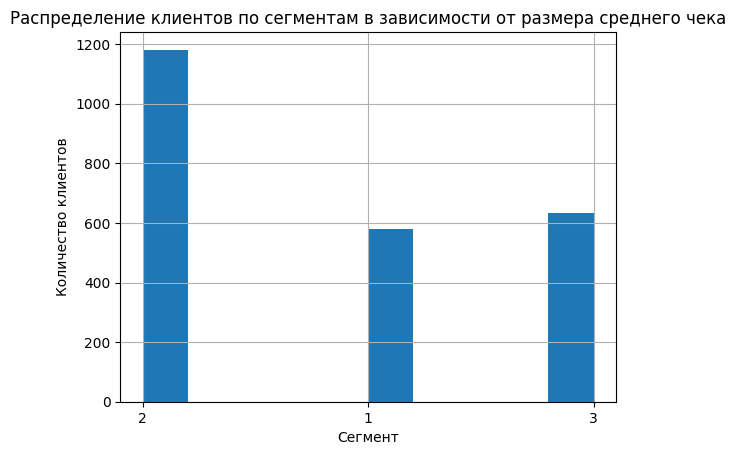

In [59]:
#Изучим количественное распределение сегментов по пользователям
mean_check['segment_monetary'].hist()
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов', rotation=90)
plt.title('Распределение клиентов по сегментам в зависимости от размера среднего чека')
;

In [60]:
mean_check.pivot_table(index = 'segment_monetary', values = 'customer_id', aggfunc = 'count')

,customer_id
segment_monetary,
1,580
2,1181
3,632


Видим сегментацию немного напоминающую разбивку клиентов по давности покупки: 50% клиентов находится в зоне среднего среднего чека; по 25% пользователей распределились между высоким и низким средним чеком.

Добавим разбивку по егментам в основной датасет.

In [61]:
df = pd.merge(df, mean_check, how ='left', on ='customer_id')
df

,date,customer_id,order_id,product,quantity,price,revenue,month,count_orders,segment_frequency,between_buy_and_end,between_lastbuy_and_end,segment_recency,a,sum_by_order,mean_check,segment_monetary
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10,1,3,396 days,396 days,3,396,1037.0,1037.0,2
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10,1,3,396 days,396 days,3,396,1037.0,1037.0,2
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10,1,3,396 days,396 days,3,396,1037.0,1037.0,2
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10,1,3,396 days,396 days,3,396,1037.0,1037.0,2
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10,1,3,396 days,396 days,3,396,1037.0,1037.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4801,2019-10-30 21:00:00,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,314.0,2019-10,1,3,1 days,1 days,1,1,314.0,314.0,2
4802,2019-10-31 09:00:00,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,112.0,2019-10,1,3,0 days,0 days,1,0,112.0,112.0,3
4803,2019-10-31 11:00:00,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,2019-10,1,3,0 days,0 days,1,0,329.0,329.0,2
4804,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,2019-10,1,3,0 days,0 days,1,0,1087.0,1087.0,2


Получается при классическом RFM-анализе, у нас получится 27 сегментов... Пожалуй, для заказчика это будет много для дальнейшей обработки. Укрупним сегменты. Я буду делать так: критерий частоты покупок я выкидываю - он перекашивает кластеры, т.к. у нас большинство клиентов с одним единственным заказом. По давности и среднему чеку оставлю по 2 сегмента - недавние и давние клиенты; средний чек выше среднего и ниже среднего. Предыдущий код в пунктах 2.2-2.4 я оставлю на всякий случай. Новую сегентацию буду писать ниже тут. В пунктах с формированием кластеров и оценке товарных категорий и сезонности я также оставляю старый код, а новые блоки по новой укрупненной кластеризации буду писать после своего синего комментария.

### RM - анализ: давность покупок

Разбивать будем по медианному значению между последним заказом клиента и концом выгрузки.

Примем, что:

- 1 - недавно заказавшие - клиенты, совершившие свой последний заказ менее 7 месяцев назад (212 дней);
- 2 - давно заказавшие - клиенты, совершившие  свой последний заказ более 7 месяцев назад (212 дней).

In [62]:
#Напишем функцию для сегментации
def segment_recency_new(z): 
    if z <= 212:
        return '1'
    else:
        return '2'

#Создадим столбец с сегментом клиента, прмиенив функцию
time_interval['segment_recency_new']=time_interval['a'].apply(segment_recency_new)


In [63]:
#Перенесем информацию из временной таблицы о давности заказов и сегменте по каждому пользователю в основной датасет
df = pd.merge(df, time_interval[['customer_id', 'segment_recency_new']], how ='left', on ='customer_id')

### RM - анализ: средний чек

Разобьем клиентов по медианному значению среднего чека.

Примем, что:

- 1 - клиенты со средним чеком выше среднего по выборке (676 руб.);
- 2 - клиенты со средним чеком ниже среднего по выборке (676 руб.).

In [64]:
#Напишем функцию для сегментации
def segment_monetary_new(w): 
    if w >= 676:
        return '1'
    else:
        return '2'


In [65]:
#Создадим столбец с сегментом клиента, прмиенив функцию
mean_check['segment_monetary_new']=mean_check['mean_check'].apply(segment_monetary_new)

In [66]:
df = pd.merge(df, mean_check[['customer_id', 'segment_monetary_new']], how ='left', on ='customer_id')

### Кластеризация клиентов

In [67]:
#Объединяем в один кластер все 3 параметра
df['client_clasters'] = df['segment_frequency']+df['segment_recency']+df['segment_monetary']
df['client_clasters'].nunique()

21

In [68]:
df['client_clasters'].unique()

array(['332', '333', '122', '131', '331', '232', '221', '222', '231',
       '233', '322', '321', '323', '223', '212', '213', '312', '313',
       '311', '211', '112'], dtype=object)

Еще раз, чтобы не запутаться, первое число означает частоту покупок; второе - давность; третье - средний чек. У нас получилось выделить 21 клиентский кластер - это меньше потенциально возможного числа, т.к. отсутствует ряд кластеров, например 111 - клиенты, которые покупают часто, недавно и с высоким средним чеком. 
Определим вес каждого кластера в клиентской базе

In [69]:
clasters = df.pivot_table(index = 'client_clasters', values = 'customer_id', aggfunc = 'count').reset_index()\
.sort_values(by = 'customer_id', ascending = False)
clasters

,client_clasters,customer_id
16,322,1104
15,321,832
19,332,530
18,331,367
13,312,336
17,323,334
7,222,322
14,313,170
1,122,143
12,311,136


Видно, что у нас есть совсем малочисленные кластеры - в самом маленьком всего 4 человека. Сфокусируемся на крупных клиентских кластерах, где больше 100 пользователей. Остальных выведем в категорию "прочих".

In [70]:
clasters_big = clasters.query('customer_id>100')
clasters_big
t = {'client_clasters': 'прочие', 'customer_id': clasters.query('customer_id<100')['customer_id'].sum()}
t
clasters_big = clasters_big.append(t, ignore_index = True)
clasters_big


<ipython-input-70-8eba176086f7>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,client_clasters,customer_id
0,322,1104
1,321,832
2,332,530
3,331,367
4,312,336
5,323,334
6,222,322
7,313,170
8,122,143
9,311,136


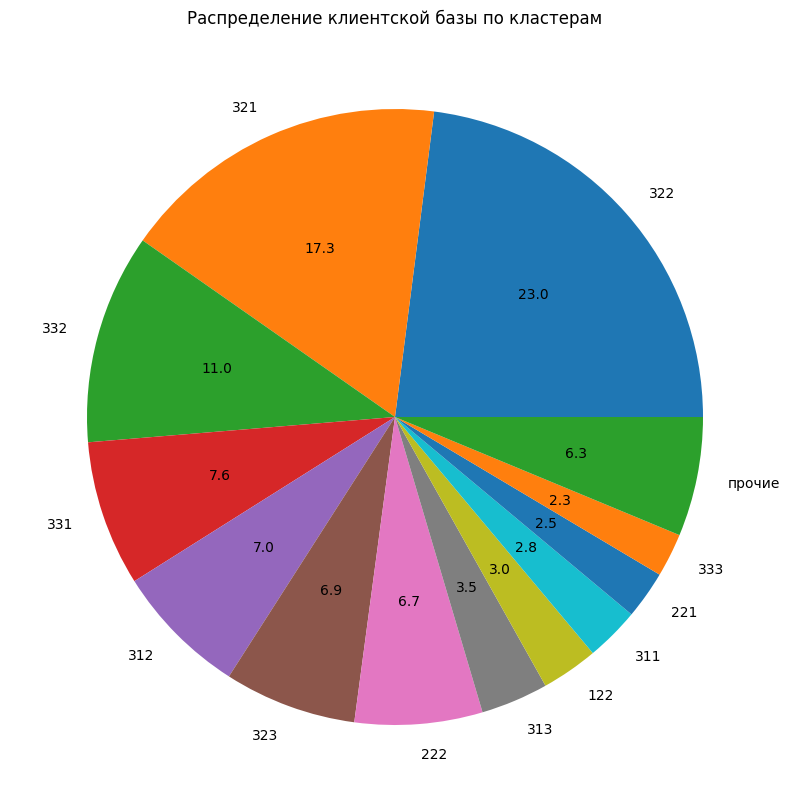

In [71]:
fig = plt.figure(figsize =(15, 10))
plt.pie(clasters_big['customer_id'], labels = clasters_big['client_clasters'], autopct='%.1f')
plt.title("Распределение клиентской базы по кластерам")
plt.show()

50% нашей клиентской базы - это клиенты, которые делали разовые покупки, довольно давно или среднесрочно, но с высоким или средним чеком. Продолжим анализ, чтобы для каждого кластера подобрать товарную категорию в соответствии со спросом и сезонностью.

Новая разбивка по кластерам ниже - останавливаемся на 4х кластерах.

In [72]:
#Объединяем в один кластер все 3 параметра
df['client_clasters_new'] = df['segment_recency_new']+df['segment_monetary_new']
df['client_clasters_new'].nunique()

4

In [73]:
clasters_new = df.pivot_table(index = 'client_clasters_new', values = 'customer_id', aggfunc = 'nunique').reset_index()\
.sort_values(by = 'customer_id', ascending = False)
clasters_new

,client_clasters_new,customer_id
1,12,639
2,21,637
0,11,562
3,22,555


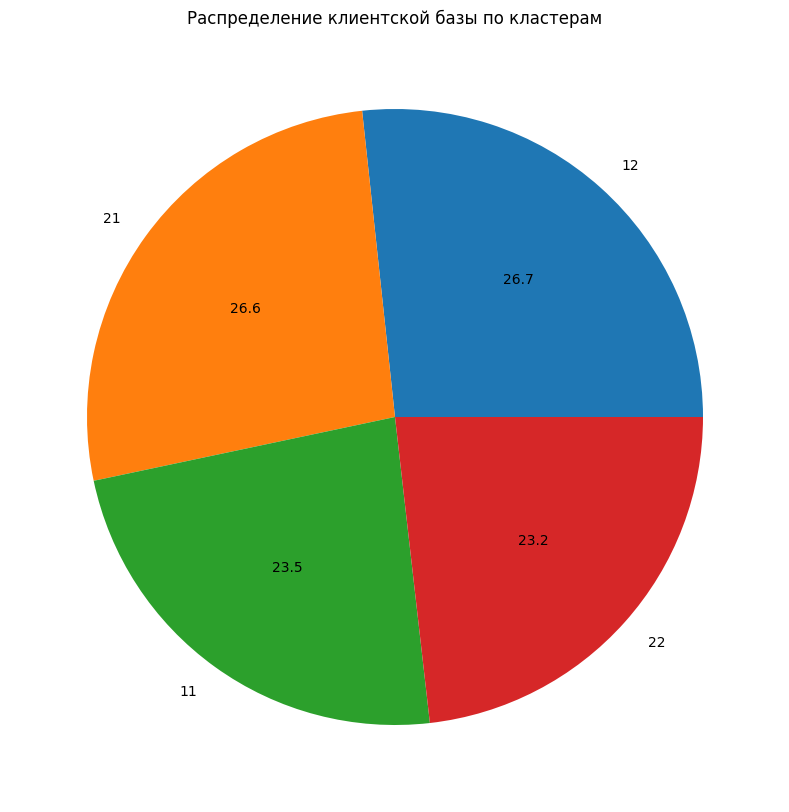

In [74]:
fig = plt.figure(figsize =(15, 10))
plt.pie(clasters_new['customer_id'], labels = clasters_new['client_clasters_new'], autopct='%.1f')
plt.title("Распределение клиентской базы по кластерам")
plt.show()

Разбивка выборки:
- сегмент 11 - клиенты с недавними покупками и высоким средним чеком - 23,5%
- сегмент 12 - клиенты с недавними покупками и низким средним чеком - 26,7%
- сегмент 21 - клиенты с давними покупками и высоким средним чеком - 26,6%
- сегмент 22 - клиенты с давними покупками и низким средним чеком - 23,2%.

### Товарные категории и сезонность

Перед нами нетривиальная задача - распределение товаров по категориям в зависимости от наименования товара... Довольно странно, что исходная выгрузка не содержит подобных данных, ведь на сайте наверняка должны быть товарные каталоги в разбивке по категориям... Если этого нет - не удивительно, что так мало пользователей делают повторные покупки: клиенты просто не ориентируются на сайте.

Какой план действий: видно, что основная характеристика товара содержится в первых двух словах столбца `product`. Попробуем выделить два этих ключевых слова в отдельные столбцы, а далее будем составлять списки, содержащие облако ключевых слов по заданным категориям. Чтобы избежать ошибок неверного отнесения товаров к категории, будем вручную просматривать ту или иную категорию и, при необходимости, дополнять облако ключевых слов в той или иной категории.

In [75]:
#Приводим продукт к нижнему регистру и берем два первых слова
df['product']=df['product'].str.lower()
df['keyword1'] = df['product'].str.split(' ').apply(lambda x: x[0])
df['keyword2'] = df['product'].str.split(' ').apply(lambda x: x[1])
df['key'] = df['keyword1'] + ' ' + df['keyword2']
#df = df.drop(columns=['keyword1', 'keyword2']) 
#df['key'].sort_values().unique()
#Просматриваем уникальные слова, содержащиеся в первом слове названия продукта
df['keyword1'].sort_values().unique()

array(['tepмокружка', 'автоматическая', 'агератум', 'адиантум', 'азалия',
       'аквилегия', 'алиссум', 'алоэ', 'альбука', 'амариллис', 'анемона',
       'антижир', 'антинакипин', 'антуриум', 'аптения', 'арбуз',
       'аргирантерум', 'ароматизированное', 'артемизия', 'аспарагус',
       'астра', 'афеляндра', 'бадан', 'базилик', 'бак', 'баклажан',
       'бакопа', 'бальзам', 'бальзамин', 'банка', 'барвинок', 'бархатцы',
       'бегония', 'бельевые', 'бензин', 'бидон', 'блюдо', 'блюдце',
       'буддлея', 'бузульник', 'бульонница', 'ваза', 'вакуумный',
       'валериана', 'ванна', 'вантуз', 'ведро', 'веник', 'венчик',
       'вербейник', 'вербена', 'веревка', 'вероника', 'весы', 'вешалка',
       'вешалка-перекладина', 'вешалка-плечики', 'вешалка-стойка',
       'вешалка-сушилка', 'вешалки', 'вигна', 'вилка', 'виола',
       'вкладыши', 'газания', 'гайлардия', 'гардения', 'гвоздика',
       'георгина', 'герань', 'гербера', 'гиацинт', 'гимнокалициум',
       'гиностемма', 'гипоаллергенн

Т.к. большой процент товаров - это растения в той или иной интерпретации, все товары, которые мы не разнесем по категориям, причислим к растениям. Также видно, что в выгрузке присутствуют:
- хозтовары и товары для дома;
- посуда и техника для кухни;
- бытовая химия;
- текстиль.

Формируем облако слов по категориям в виде списков.

In [76]:
#Списки ключевых слов по категориям
dishes = ['универсальный','tepмокружка', 'блюдо', 'блюдце', 'бульонница', 'ваза', 'венчик', 'вилка', 'картофелемялка',\
          'кастрюля', 'кипятильник', 'кисточка', 'ковш', 'кружка', 'крышка', 'кувшин', 'кухонное', 'кухонные', 'ложка',\
          'лопатка', 'мантоварка', 'мантоварка-пароварка', 'масленка', 'мини-сковорода', 'миска', 'нож', 'ножеточка',\
          'овощеварка','овощечистка', 'орехоколка', 'половник', 'противень', 'разделочная', 'решетка', 'рыбочистка',\
          'салатник', 'салфетница', 'сахарница', 'сервировочная', 'сито', 'скалка', 'сковорода', 'соковарка',\
          'соковыжималка', 'сотейник', 'стакан', 'тарелка', 'терка', 'термокружка', 'термос', 'термостакан', 'толкушка'\
         'тортница', 'форма', 'хлебница', 'чайная', 'чайник', 'чайный'\
         'бокалов', 'кружек', 'кружка', 'крышка', 'ложка', 'нож', 'ножей', 'посуды', 'стакан', 'стаканов', 'стеклянная'\
          'фужеров', 'лопатка', 'пресс', 'стеклянная', 'столовая', 'столовый', 'толкушка', 'тортница'\
         'универсальный', 'фарфоровая', 'чайный', 'тортница', 'модульная', 'мерный', 'мантоварка', 'миксер'\
         'измельчитель', 'лоток']
house = ['муляж','автоматическая','бак', 'банка', 'бельевые', 'бензин', 'бидон', 'ванна', 'вантуз', 'ведро',\
         'веник', 'веревка', 'весы', 'вешалка',\
         'вешалка-перекладина', 'вешалка-плечики', 'вешалка-стойка', 'вешалка-сушилка', 'вешалки', 'вкладыши',\
         'гладильная','губка', 'держатель', 'дозатор', 'доска', 'емкость', 'ерш', 'жестяная',\
         'измерительный', 'карниз',\
         'ключница','ковер', 'коврик','ковёр', 'комод', 'контейнер', 'корзина', 'корзинка','короб','коробка', 'корыто',\
         'котел', 'кофр', 'крепеж', 'крючок', 'лестница', 'лестница-стремянка', 'линейка,', 'мешок', 'миксер'\
        'муляж', 'мусорный', 'мыльница', 'насадка', 'насадка-моп', 'насадка-отжим', 'обувница-3', 'окномойка',\
         'перчатки', 'петля', 'петля-стрела', 'плечики', 'подголовник', 'подрукавник', 'подставка', 'покрытие',\
         'полка', 'полки', 'прищепки', 'пробка', 'просеиватель', 'пружина', 'пылесос', 'пьезозажигалка', 'рассекатель'\
        'ролик','рукав', 'ручка', 'ручка-скоба', 'сверло', 'сверло-фреза,', 'светильник', 'сетка', 'сиденье',\
         'скребок', 'совок', 'стеллаж', 'стремянка','стремянка-табурет', 'стремянки', 'стяжка', 'стяжки',\
         'сумка', 'сумка-тележка', 'сушилка', 'таз', 'таз', 'тележка', 'термометр', 'тряпка','тряпкодержатель',\
         'уголок', 'урна', 'урна-пепельница', 'утюг', 'фал', 'фен', 'фиксатор-шар',  'фоторамка', 'чехол', 'швабра',\
         'шило', 'шнур', 'шпагат', 'шпингалет', 'шприц', \
         'штанга', 'штангенциркуль', 'щетка', 'щетка-сметка', 'щетка-утюжок', 'щётка', 'электроштопор', 'этажерка'\
        'ящик', 'ёрш',\
         'алюминиевая', 'алюминиевый,', 'балконное', 'блок', 'вешалок', 'войлочная', 'гладильная', 'деревянная'\
        'детская', 'детский', 'диск', 'кашпо', 'коробка', 'ковров', 'награда', 'насадка', 'пакет', 'прищепок'\
        'сварка', 'смесь', 'соль', 'стимул', 'сушилка', 'щетка', 'экран', 'электрический', 'эмалированных'\
        'автоматическая', 'вакуумный', 'запасная', 'защитная', 'защитный', 'многофункциональный', 'модульная'\
        'муляж', 'настенная', 'настольная', 'основание', 'отделитель', 'отжим', 'подвесное', 'ролик'\
        'складная', 'складной', 'сменная', 'сменный', 'сметка', 'совок', 'стеллаж', 'фал', 'фен', 'холодная', 'хоста'\
        'ящик', 'ящик', 'этажерка', 'складная', 'рассекатель', 'любисток', 'кольца', 'декоративная', 'набор']
chemicals = ['кондиционер', 'антижир', 'антинакипин', 'ароматизированное', 'бальзам', 'гипоаллергенный',\
             'жидкое', 'зубная', 'концентрат',\
            'мыло', 'мыло-скраб', 'ополаскиватель', 'отбеливатель', 'паста', 'пена', 'средство', 'стиральный',\
            'увлажняющая', 'чистящий'\
            'биопорошок', 'крем', 'средство'\
            'кондиционер', 'универсальное', 'чистящий']
tekstile = ['двуспальное', 'махровое', 'наволочка', 'наматрасник', 'наматрацник', 'наматрицник-чехол',\
            'нетканые', 'одеяло'\
           'плед', 'подкладка', 'пододеяльник', 'подушка', 'покрывало', 'полотенце', 'простынь', 'простыня','салфетка',\
           'скатерть', 'ткань', 'халат', 'штора'\
           'постельного', 'скатерть', 'халат', 'одеяло', 'штора', 'плед', 'махровый','готовая'\
           'комплект']

In [77]:
#Функция для присвоения категорий
def categ_product(types):

        if types in house:
            return "дом"
        if types in dishes:
            return "посуда"
        if types in chemicals:
            return "бытовая химия"
        if types in tekstile:
            return "текстиль"

In [78]:
#Применяем функцию к первову слову из названия товара
df['category'] = df['keyword1'].apply(categ_product)
df['category'].unique()

array([None, 'дом', 'текстиль', 'посуда', 'бытовая химия'], dtype=object)

In [79]:
#Все нераспределенные товары относим к растениям
df['category']=df['category'].fillna('растения')

In [80]:
#Просмотрим товары на предмет корректного распределения по категориям
#pd.set_option('display.max_rows', None)
#df.query('category == "растения"')[['product', 'key', 'category']].sort_values(by='product')


Товарные категории выделены. Изучим, какая из категорий принесла большую выручку.

In [81]:
category_income=df.pivot_table(index = 'category', values = 'revenue', aggfunc = 'sum')\
.reset_index()\
.sort_values(by = 'revenue', ascending = False)
category_income


,category,revenue
1,дом,2376324.0
3,растения,542884.0
4,текстиль,313545.0
2,посуда,173855.0
0,бытовая химия,13007.0


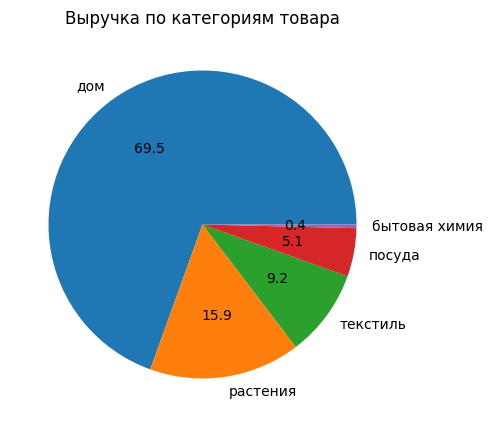

In [82]:
fig = plt.figure(figsize =(8, 5))
plt.pie(category_income['revenue'], labels = category_income['category'], autopct='%.1f')
plt.title("Выручка по категориям товара")
plt.show()

Почти 70% выручки приходится на категорию товаров для дома и хозтоваров. 

Теперь изучим, распределение по категориям товаров в натуральном выражении.

In [83]:
category_count=df.pivot_table(index = 'category', values = 'revenue', aggfunc = 'count')\
.reset_index()\
.sort_values(by = 'revenue', ascending = False)
category_count


,category,revenue
3,растения,2580
1,дом,1757
2,посуда,267
4,текстиль,170
0,бытовая химия,32


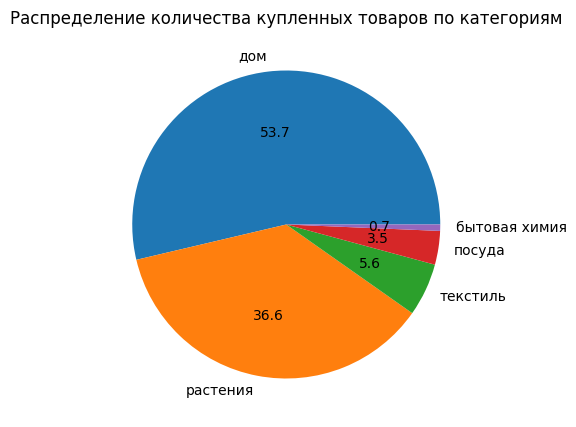

In [84]:
fig = plt.figure(figsize =(8, 5))
plt.pie(category_count['revenue'], labels = category_income['category'], autopct='%.1f')
plt.title("Распределение количества купленных товаров по категориям")
plt.show()

Более 50% заказов совершено на категорию товаров для дома. Вторая по популярности категория - растения.

Изучим топы товаров по объему выручки и количеству покупок внутри каждой категории. 

Для вывода топ-3 товаров внутри каждой категории в натуральном и денежном выражении, напишем функцию.

In [85]:
def top_goods (categ):
    print('*'*80)
    text1 = 'Топ товаров по размеру выручки для категории'
    print(text1, categ)
    print('*'*80)
    t1 = df.query('category == @categ').pivot_table(index = 'product', values = 'revenue', aggfunc = 'sum')\
    .reset_index()\
    .sort_values(by='revenue', ascending = False)\
    .head(3)
    print(t1)
    print('*'*80)
    text2 = 'Топ товаров частоте заказа для категории'
    print(text2, categ)
    print('*'*80)
    t2 = df.query('category == @categ').pivot_table(index = 'product', values = 'revenue', aggfunc = 'count')\
    .reset_index()\
    .sort_values(by='revenue', ascending = False)\
    .head(3)
    print(t2)
    print('*'*80)

In [86]:
#Выведем список категорий
cat_goods = df['category'].unique()
cat_goods

array(['растения', 'дом', 'текстиль', 'посуда', 'бытовая химия'],
      dtype=object)

In [87]:
#Применим функцию ко всем категориям
for c in cat_goods:
    top_goods(c)

********************************************************************************
Топ товаров по размеру выручки для категории растения
********************************************************************************
                                               product  revenue
766                          спатифиллум шопен d-12 см  11512.0
410  пеларгония зональная диам. 12 см сиреневый пол...  10780.0
438  пеларгония розебудная red pandora укорененный ...  10655.0
********************************************************************************
Топ товаров частоте заказа для категории растения
********************************************************************************
                                               product  revenue
438  пеларгония розебудная red pandora укорененный ...       64
436  пеларгония розебудная prins nikolai укорененны...       53
410  пеларгония зональная диам. 12 см сиреневый пол...       52
************************************************************

Таким образом, у нас есть список самых популярных товаров внутри каждой категории. Потенциально именно эти товары должны привлечь максимум внимания пользователей, которых мы планируем включить в рассылку.

Теперь исследуем сезонность аналогичным образом - с точки зрения объемов в натуральном и денежном выражении внутри каждой категории

In [88]:
season_cat_inc = df.pivot_table(index = ['month', 'category'], values = 'revenue', aggfunc = 'sum').reset_index()
season_cat_inc

,month,category,revenue
0,2018-10,бытовая химия,1089.0
1,2018-10,дом,269286.0
2,2018-10,посуда,17089.0
3,2018-10,растения,34802.0
4,2018-10,текстиль,28896.0
...,...,...,...
56,2019-09,текстиль,17844.0
57,2019-10,дом,166766.0
58,2019-10,посуда,5331.0
59,2019-10,растения,21966.0


''

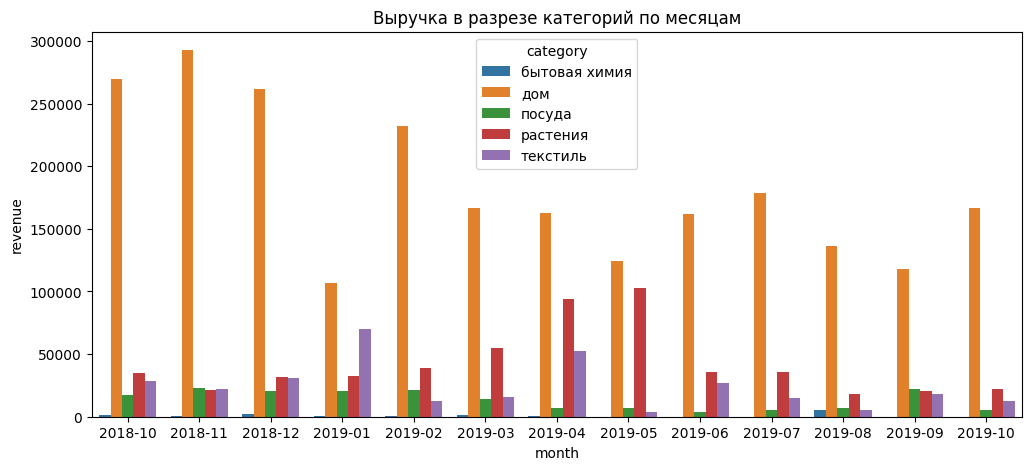

In [89]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='month', y='revenue', hue='category', data=season_cat_inc, ax=ax).set(title="Выручка в разрезе категорий по месяцам")
;

Таким образом, категория с максимальным оборотом - товары для дома - пользуется максимальным спросом в конце года - с октября по декабрь, а также в феврале. Вторая по размерам оборота категория - растения - демонстрирует логичную сезонность в весенние месяцы. Следующей по выручке является категория домашнего текстиля - максимльные размеры выручки заметны в январе и апреле - для того, чтобы сделать вывод о сезонности по этой категории необходимо изучить больший промежуток времени в выгрузке данных.

Теперь рассмотрим популярность категорий по месяцам с точки зрения количества закупаемого товара.

In [90]:
season_cat_count = df.pivot_table(index = ['month', 'category'], values = 'revenue', aggfunc = 'count').reset_index()
season_cat_count

,month,category,revenue
0,2018-10,бытовая химия,7
1,2018-10,дом,259
2,2018-10,посуда,33
3,2018-10,растения,155
4,2018-10,текстиль,28
...,...,...,...
56,2019-09,текстиль,9
57,2019-10,дом,112
58,2019-10,посуда,11
59,2019-10,растения,80


''

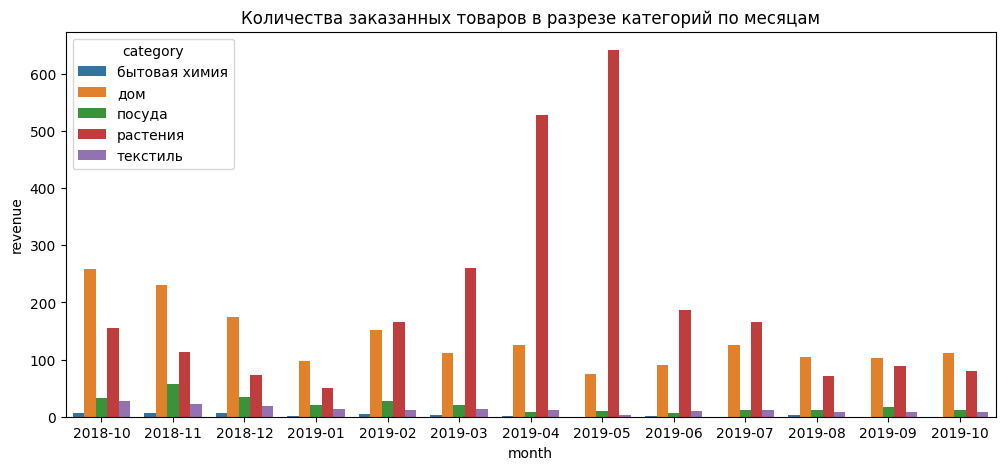

In [91]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='month', y='revenue', hue='category', data=season_cat_count, ax=ax).set(title="Количества заказанных товаров в разрезе категорий по месяцам")
;

С этого угла оценки также видно, как выделяются две товарные категории - растения и товары для дома. Количества заказываемых товаров в данных категориях частично коррелируют с объемами выручки:
- относительно товаров для дома видно, что больше всего товаров заказывают с октября по декабрь, а также в феврале; 
- относительно растений видно, что в весенние месяцы растения пользуются максимальным спросом.

Какой вывод можно сделать относительно товарных категорий и сезонности:
- собственник должен учитывать сезонность спроса при планировании товарных запасов, чтобы удовлетворять покупательский спрос;
- в преддверии высокого сезона той или иной товарой категории необходимо приземлять внимание покупателей на сайт путем тех же товарных рассылок с топом товаров.

In [92]:
#Список всех кластеров
all_clasters = df['client_clasters'].unique()
all_clasters

array(['332', '333', '122', '131', '331', '232', '221', '222', '231',
       '233', '322', '321', '323', '223', '212', '213', '312', '313',
       '311', '211', '112'], dtype=object)

In [93]:
#Функция для создания кругоых диаграмм популярности категорий товара внутри каждого кластера
def top_catgory(claster):
    top = df.query('client_clasters == @claster')\
    .pivot_table(index = 'category', values = 'revenue', aggfunc = 'sum')\
    .reset_index()\
    .sort_values(by = 'revenue', ascending = False)
    
    fig = plt.figure(figsize =(8, 5))
    plt.pie(top['revenue'], labels = top['category'], autopct='%.1f')
    plt.title(f"Популярность категорий внутри кластера {claster}")
    return plt.show()

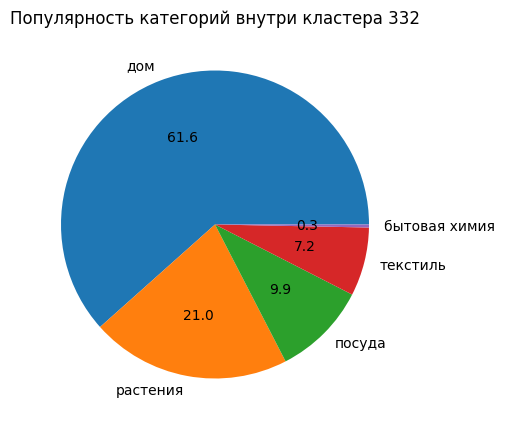

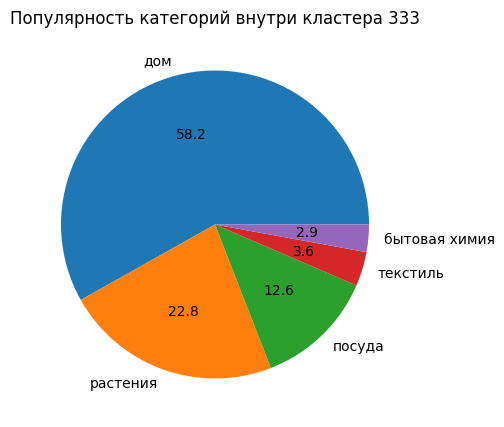

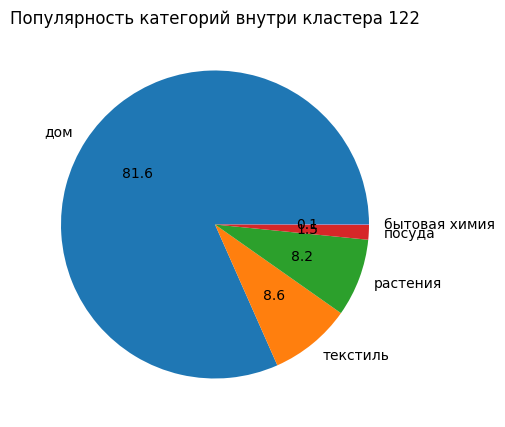

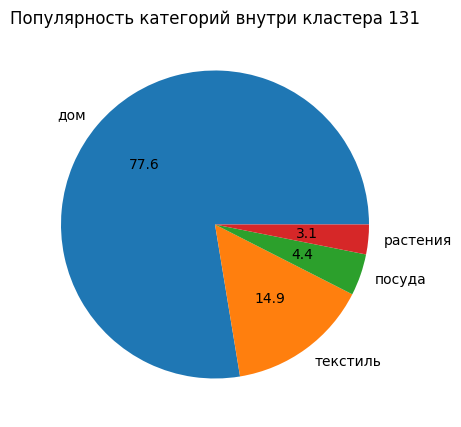

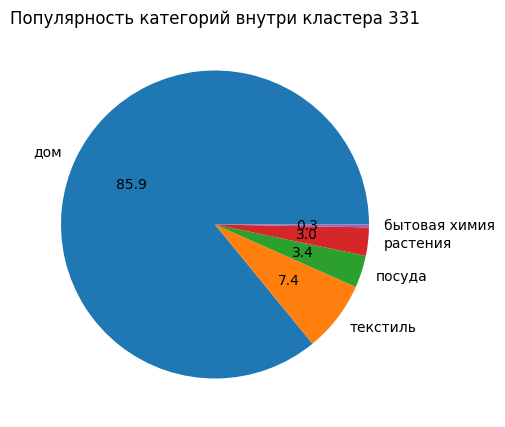

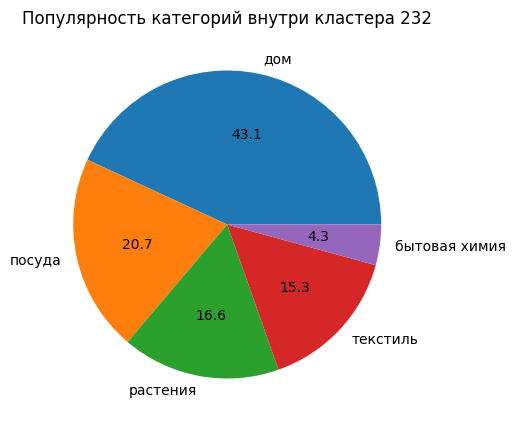

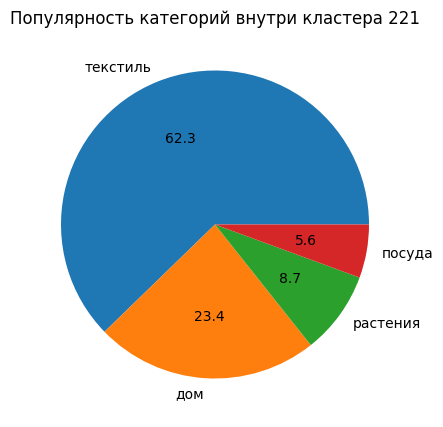

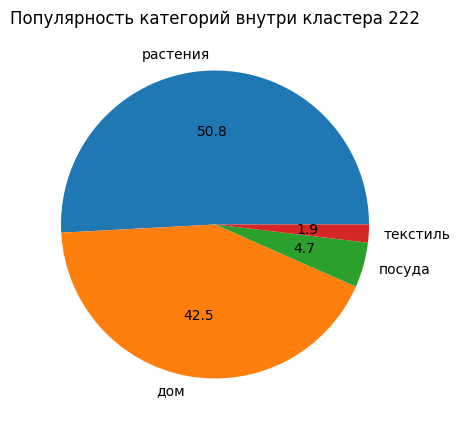

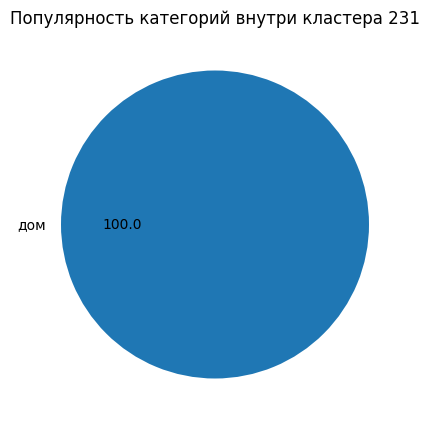

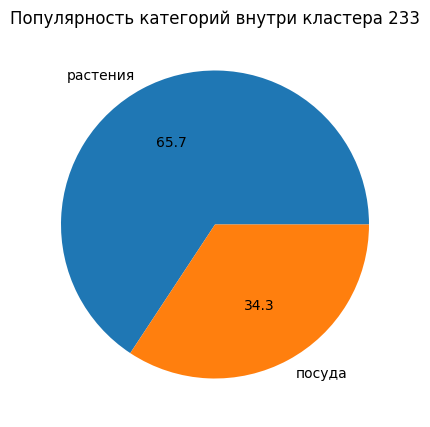

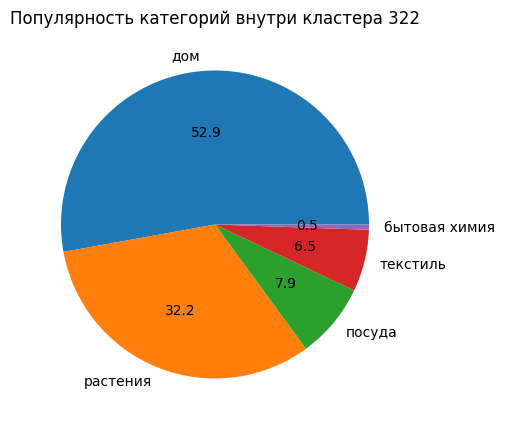

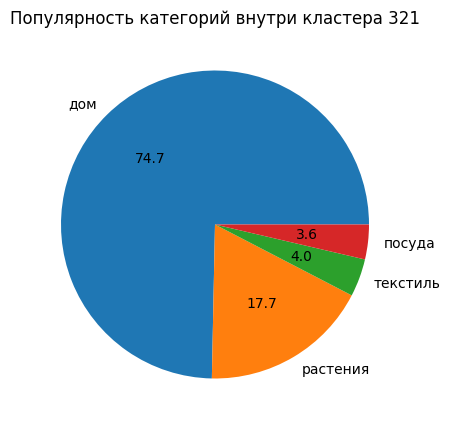

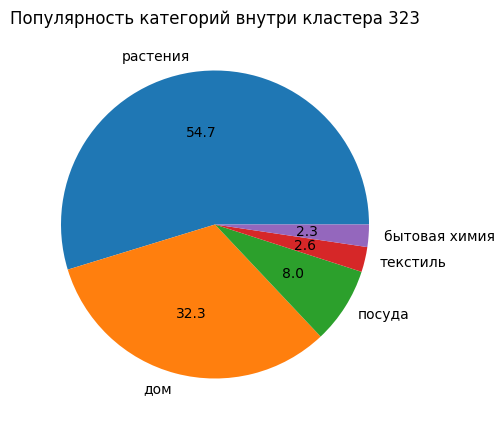

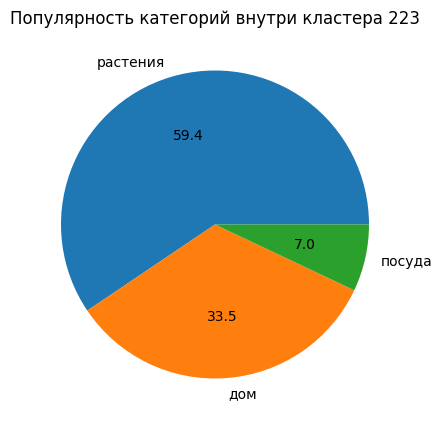

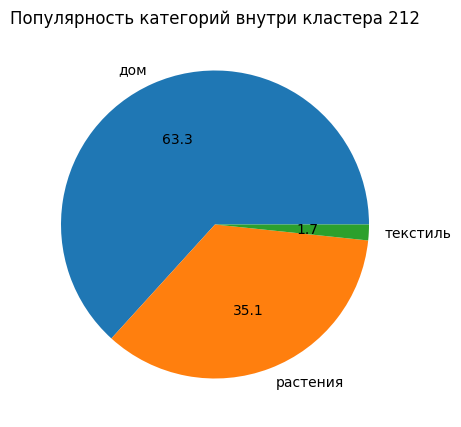

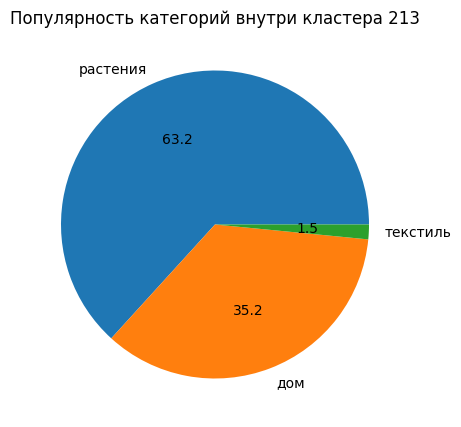

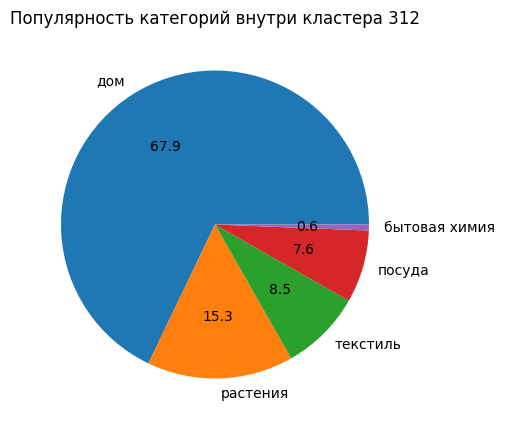

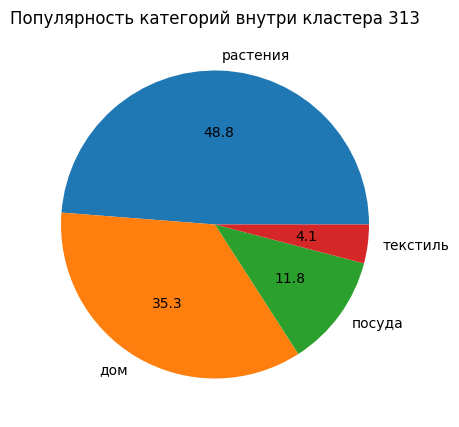

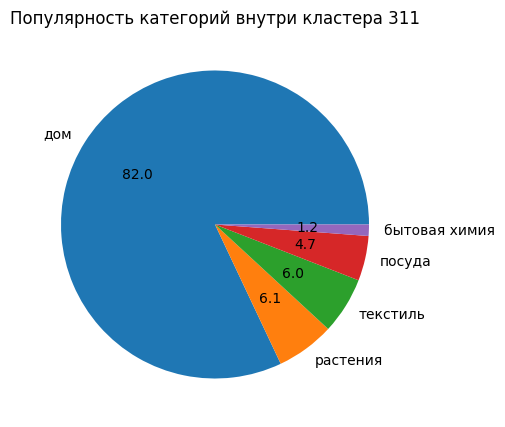

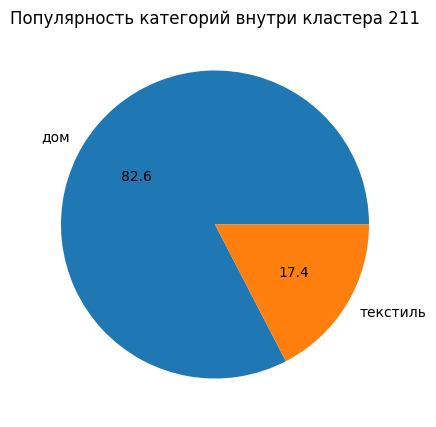

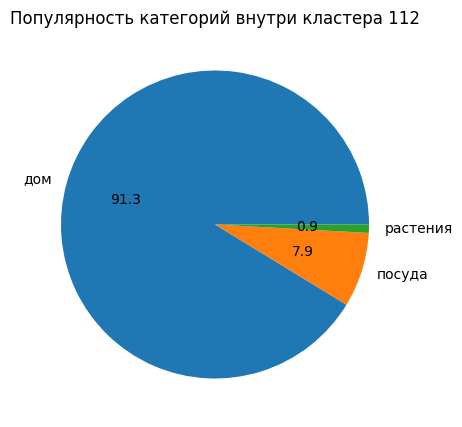

In [94]:
#Выводим распределение категорий для каждого кластера
for c in all_clasters:
    top_catgory(c)

''

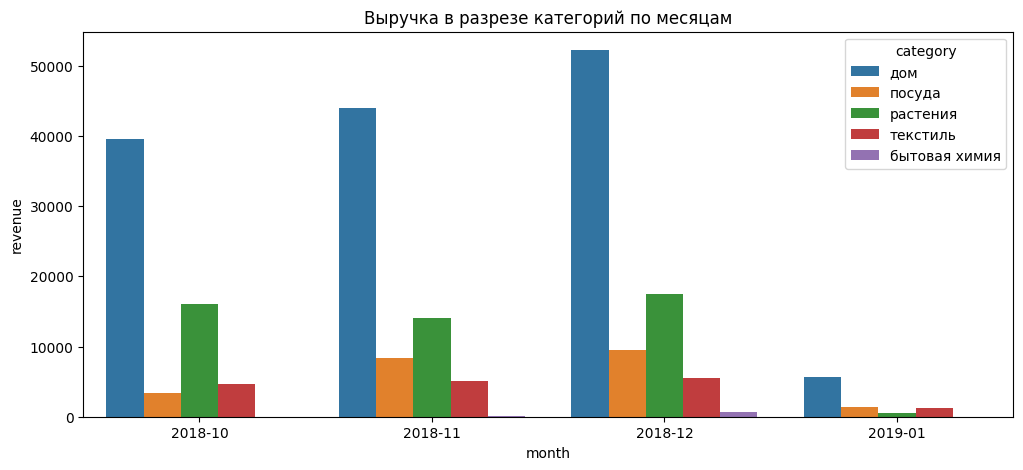

In [95]:
seasonality = df.query('client_clasters == "332"').pivot_table(index = ['month', 'category'], values = 'revenue', aggfunc = 'sum').reset_index()
seasonality
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='month', y='revenue', hue='category', data=seasonality, ax=ax).set(title="Выручка в разрезе категорий по месяцам")
;

In [96]:
#Функция для создания столбчатых диаграмм выручки по категориям товара внутри каждого кластера по сезонам
def season_catgory(claster):
    seasonality = df.query('client_clasters == @claster')\
    .pivot_table(index = ['month', 'category'], values = 'revenue', aggfunc = 'sum')\
    .reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    return sns.barplot(x='month', y='revenue', hue='category', data=seasonality, ax=ax)\
.set(title=f"Выручка в разрезе категорий по месяцам для кластера {claster}")

<ipython-input-96-570162e1b166>:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



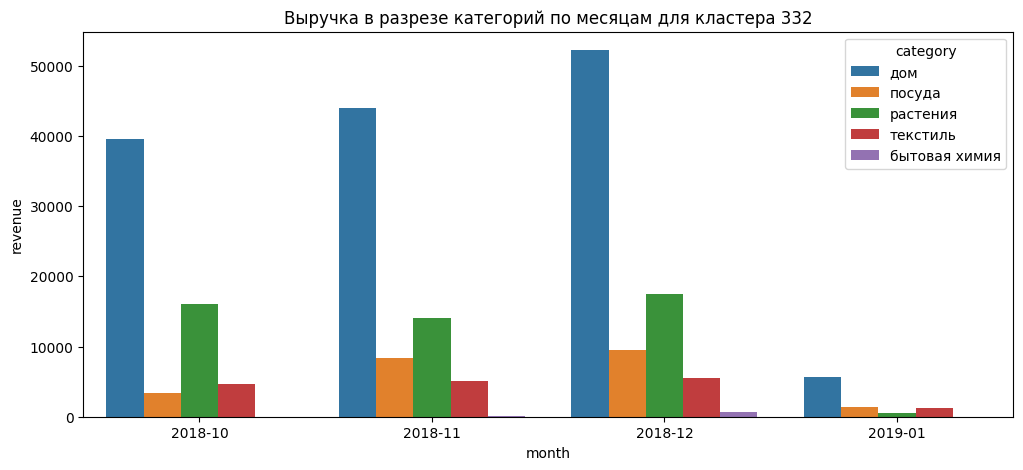

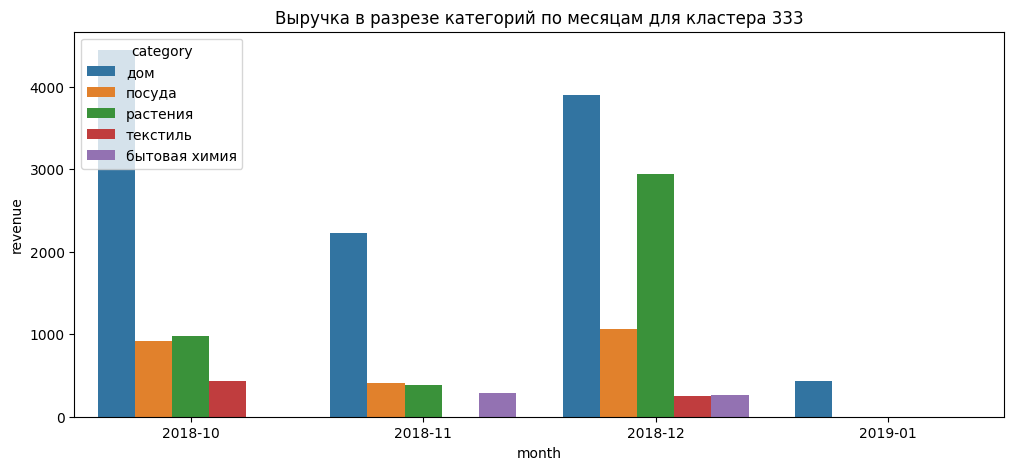

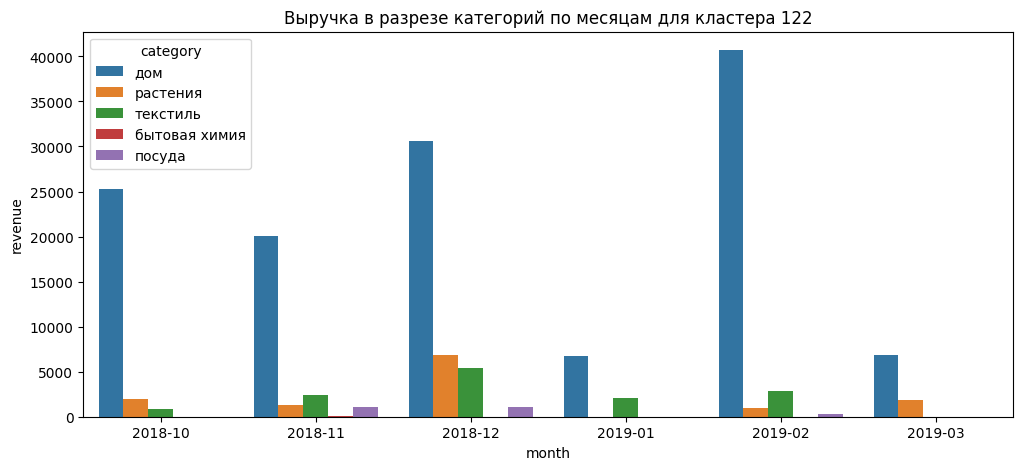

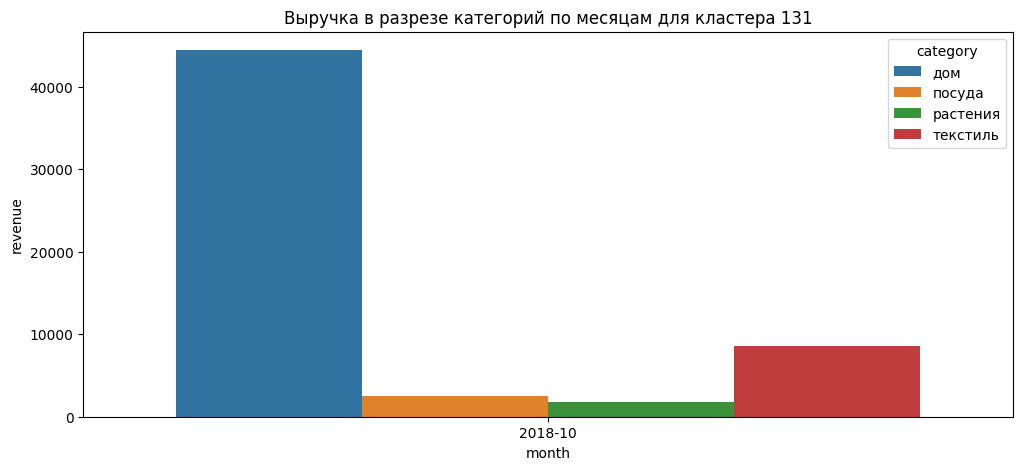

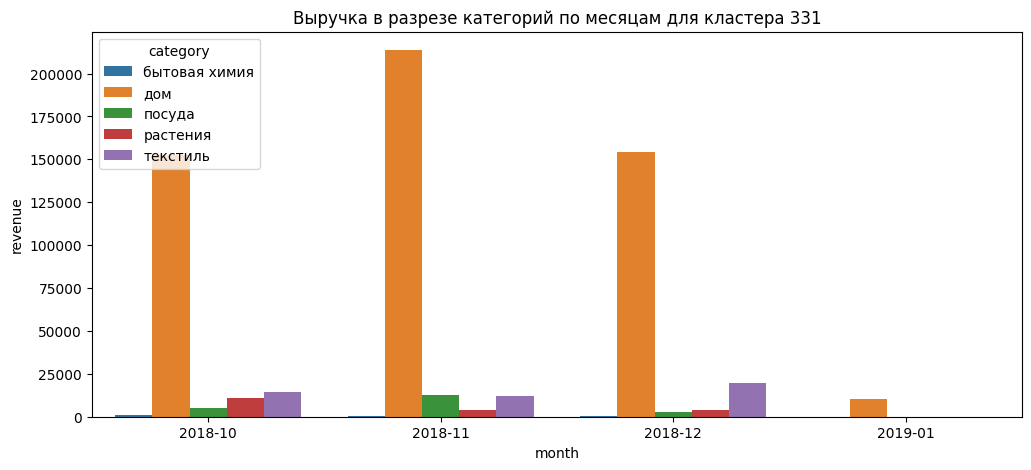

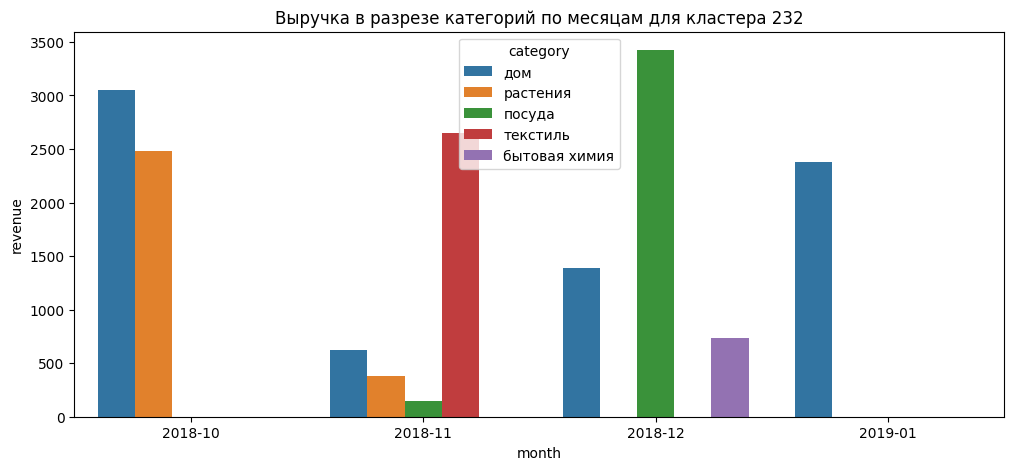

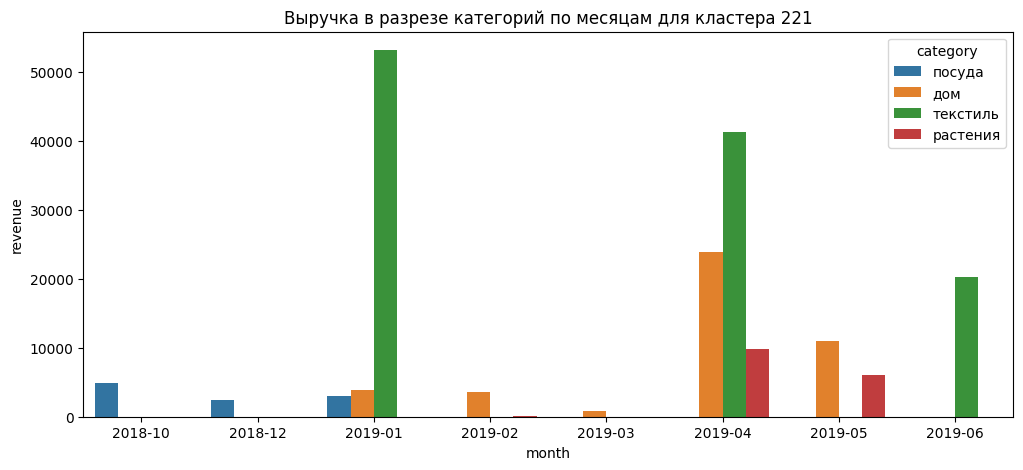

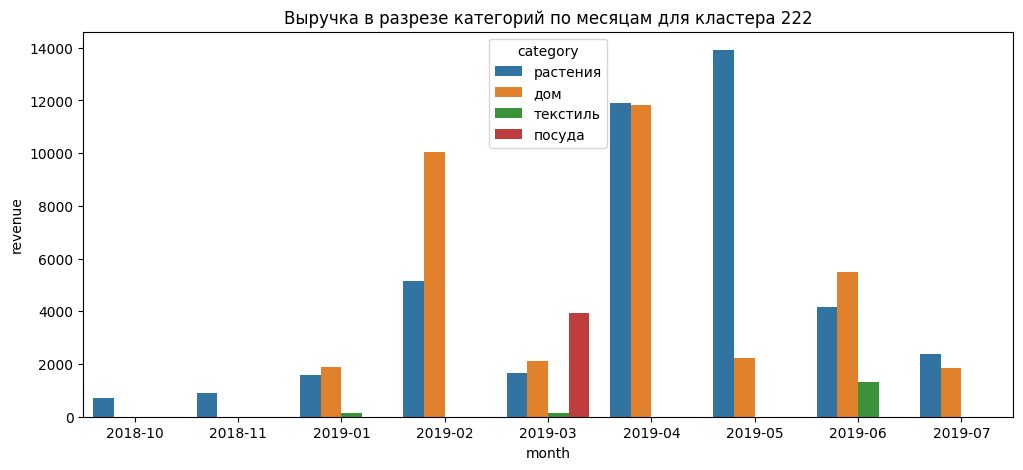

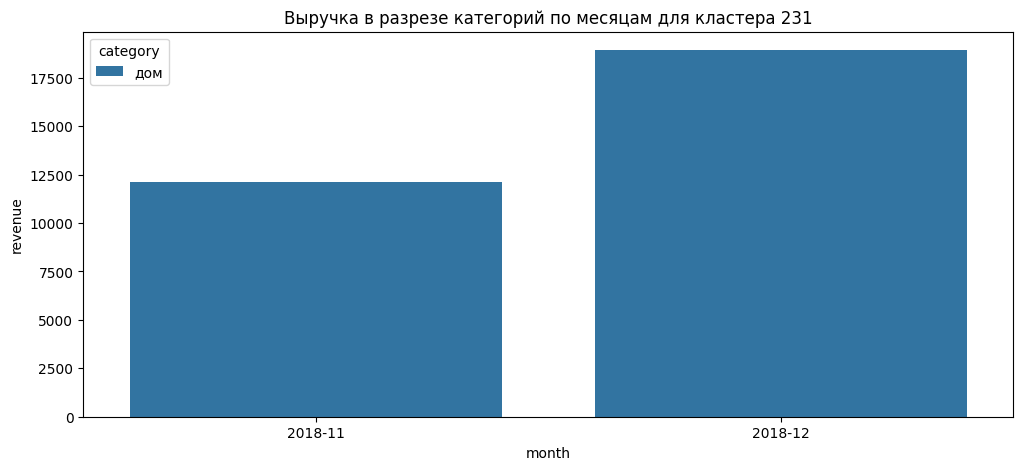

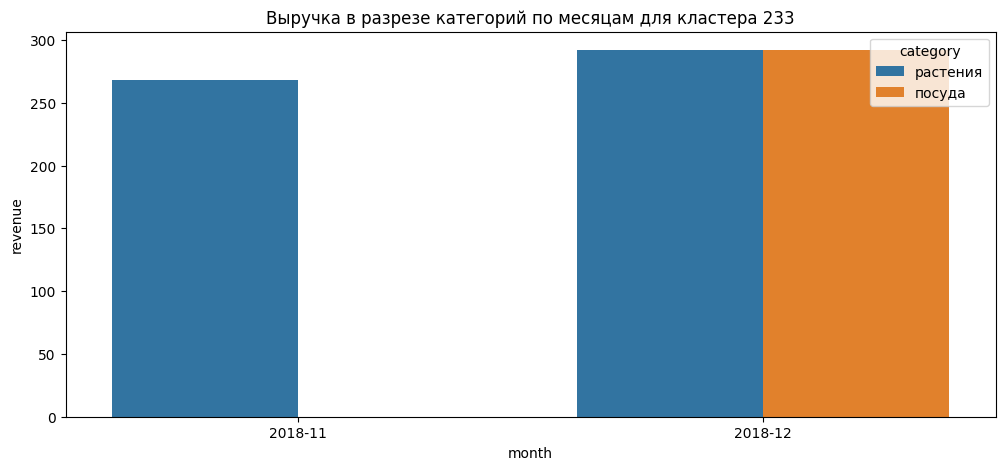

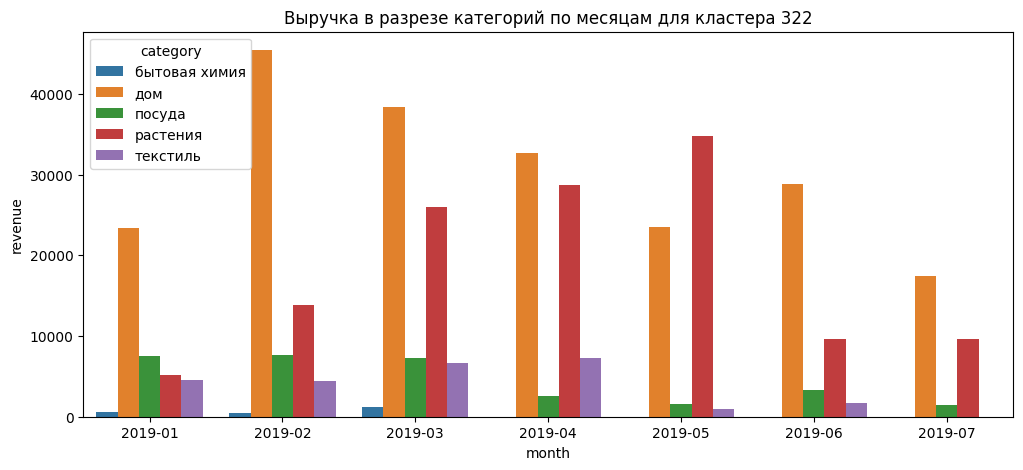

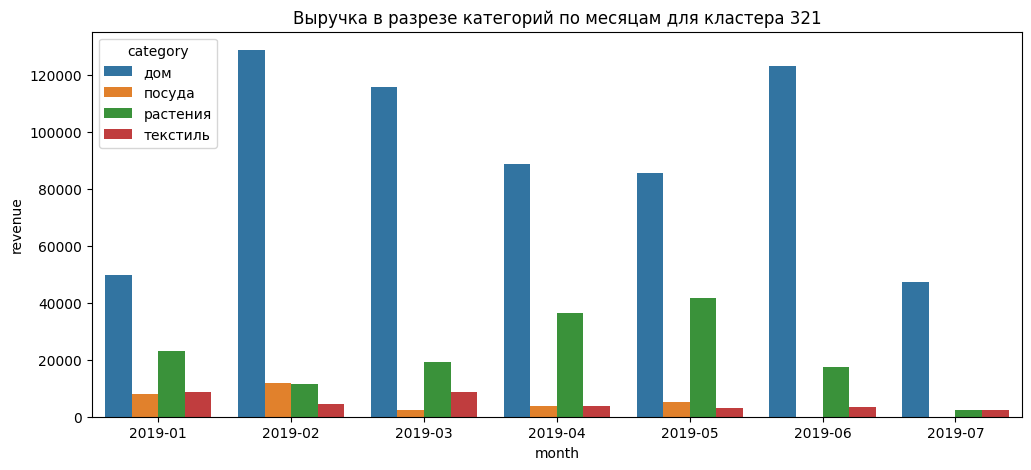

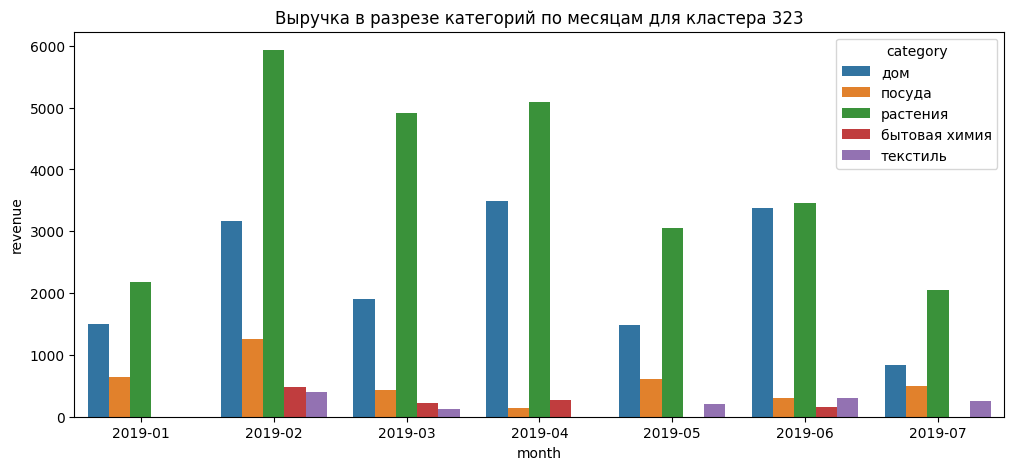

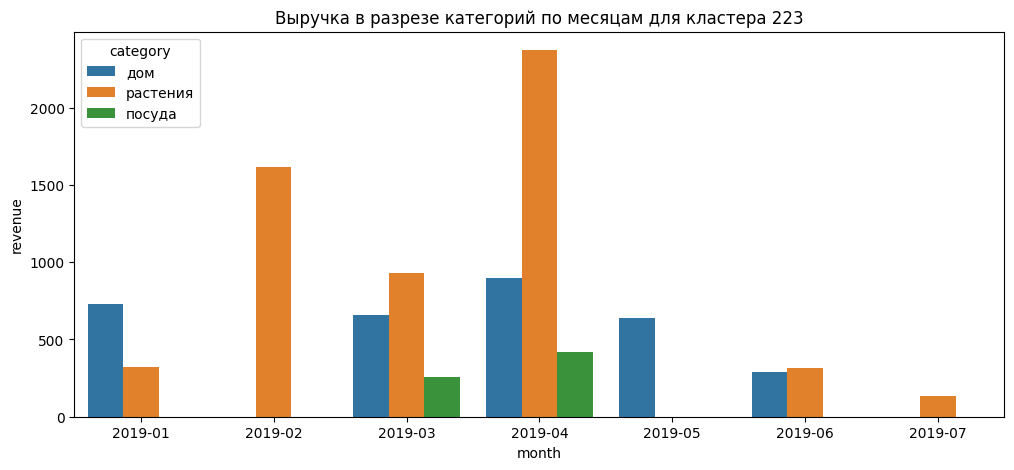

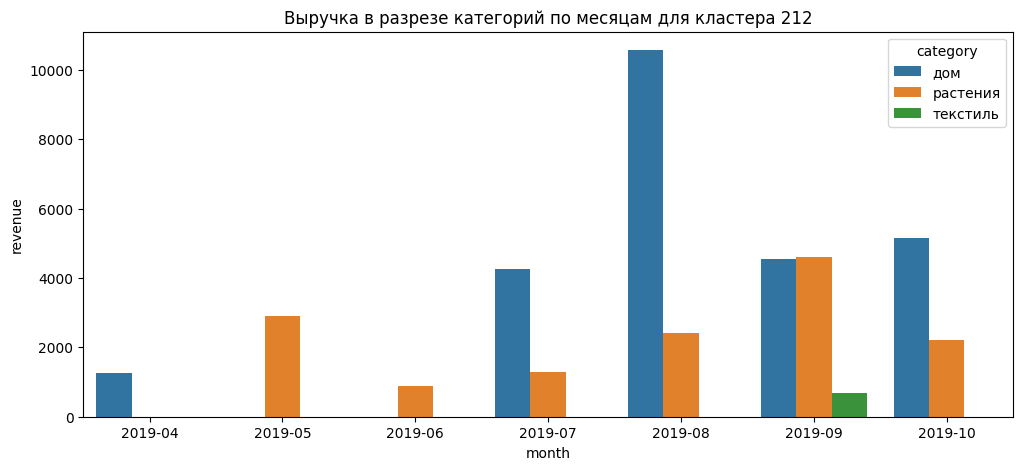

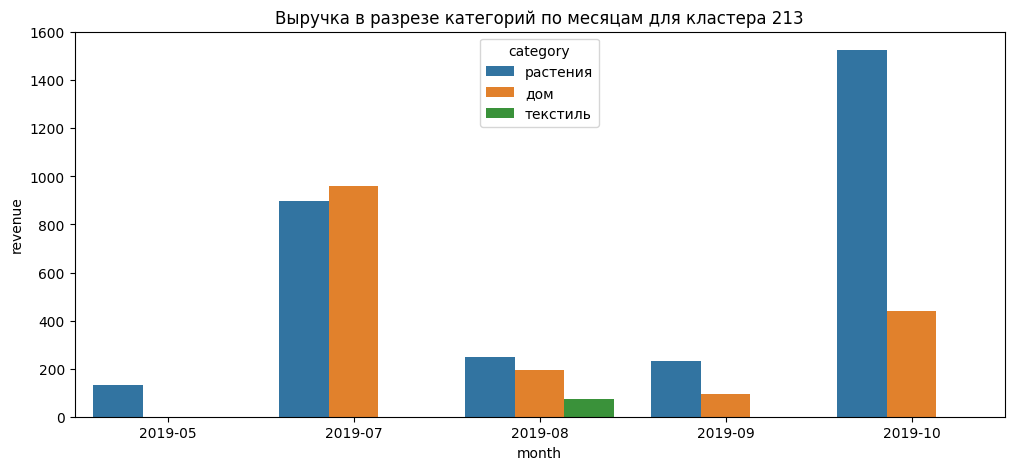

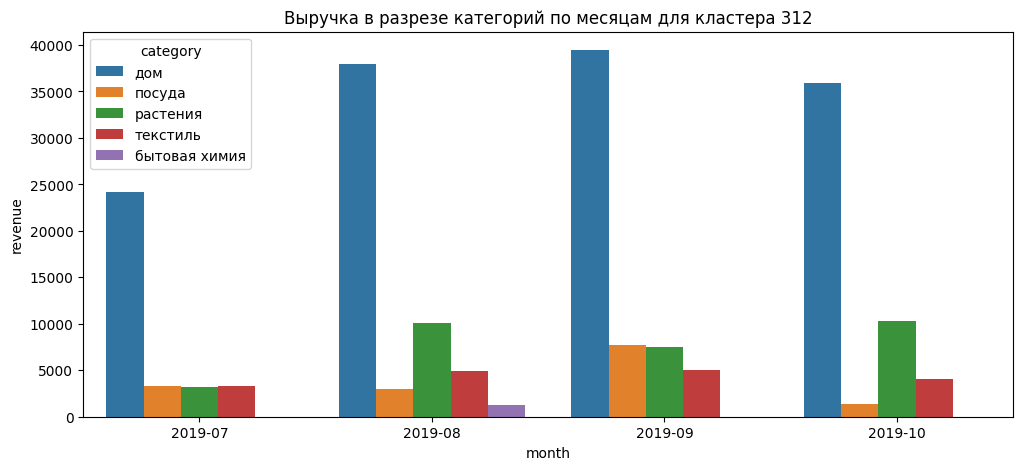

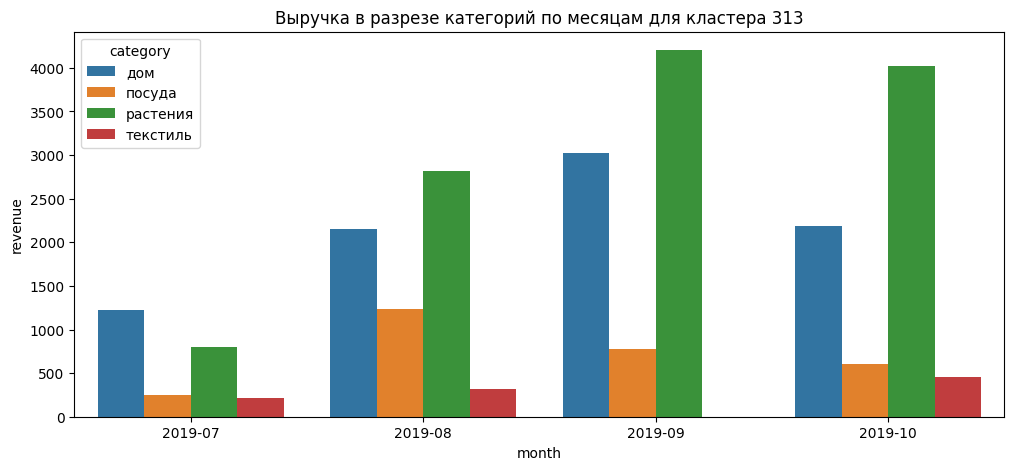

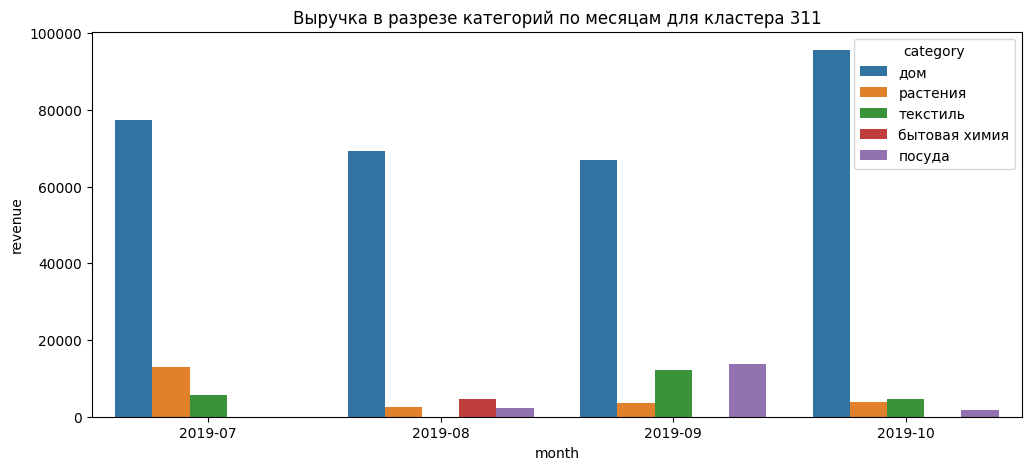

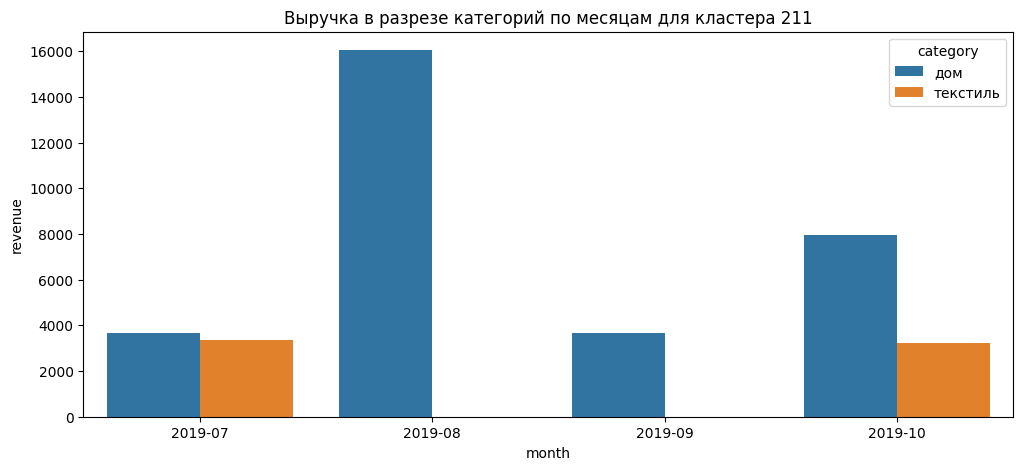

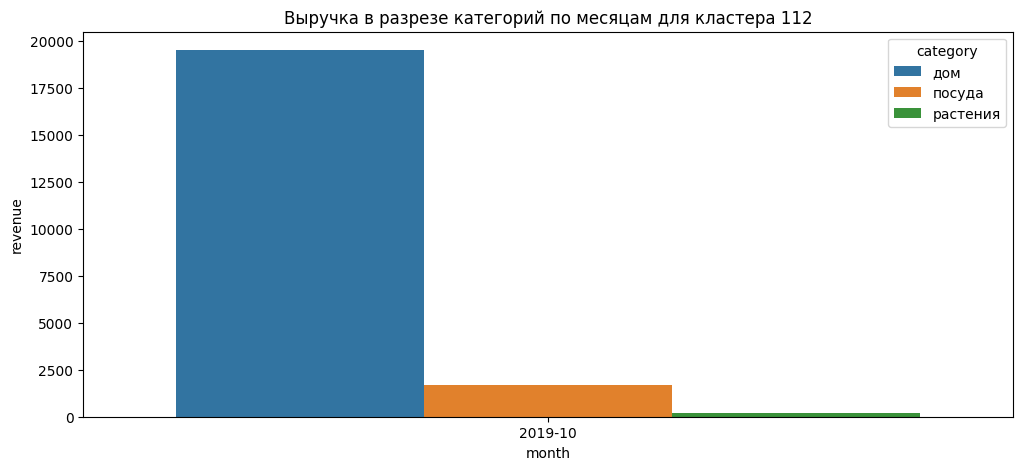

In [97]:
#Выводим сезонность объемов продаж для каждого кластера
for s in all_clasters:
    season_catgory(s)

Таким образом у нас получилось выделить 21 кластер клиента в разрезе частоты, давности покупки и среднего чека. Для каждого кластера были определены наиболее емкие товарные категории, а также учтена сезонность спроса.
Хочется выделить самые многочисленные кластеры по количеству клиентов - 322, 321 и 332. Считаю, что именно эти сегменты потенциально смогут дать наибольший профит по итогам рассылки: мы охватим больше клиентов и воронка в повторную покупку будет более эффективной.

Для выделенных кластеров наиболее емкими по выручке являются товары категории "дом", для кластера 322 также интересна категория "растения". При этом в течение года можно выделить пиковые месяцы для каждого кластера: для 332 - это октябрь, ноябрь и декабрь в категории "дом"; для 322 - это февраль, март и апрель в категории "дом" и март, апрель, май - для категории "растений"; для 321 - это февраль, март и июнь по категории "дом".

Товарные категории и сезонность в разрезе 4х кластеров ниже


In [98]:
#Функция для создания кругоых диаграмм популярности категорий товара внутри каждого кластера
def top_catgory_new(claster_new):
    top = df.query('client_clasters_new == @claster_new')\
    .pivot_table(index = 'category', values = 'revenue', aggfunc = 'sum')\
    .reset_index()\
    .sort_values(by = 'revenue', ascending = False)
    
    fig = plt.figure(figsize =(8, 5))
    plt.pie(top['revenue'], labels = top['category'], autopct='%.1f')
    plt.title(f"Популярность категорий внутри кластера {claster_new}")
    return plt.show()

In [99]:
#Список новых кластеров
all_clasters_new = df['client_clasters_new'].unique()
all_clasters_new

array(['21', '22', '11', '12'], dtype=object)

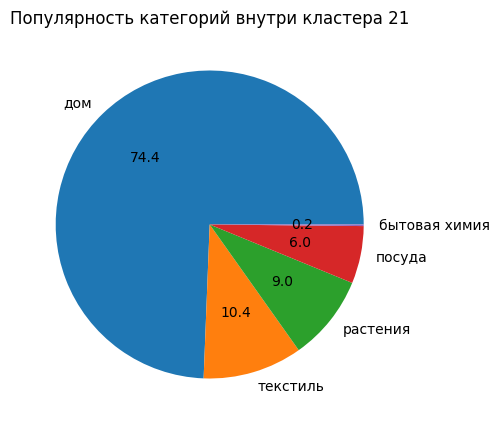

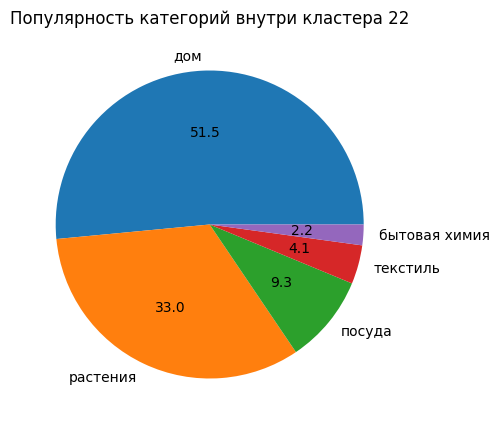

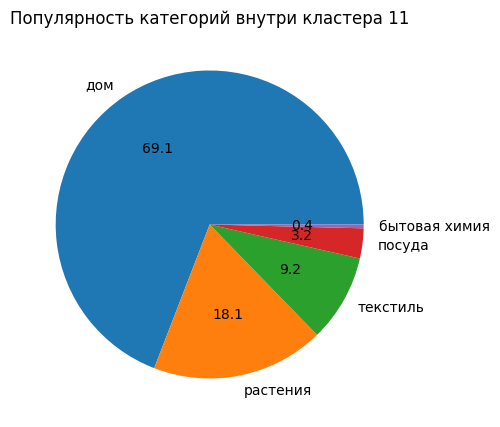

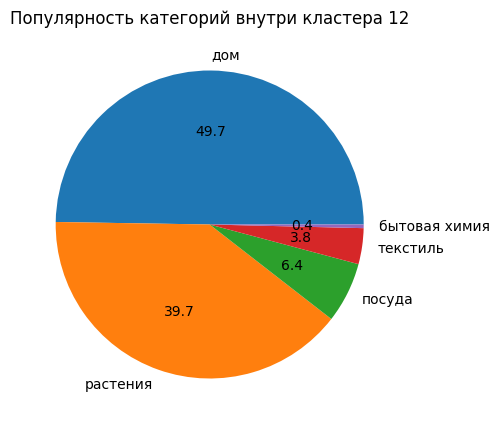

In [100]:
#Выводим распределение категорий для каждого кластера
for r in all_clasters_new:
    top_catgory_new(r)

In [101]:
#Функция для создания столбчатых диаграмм выручки по категориям товара внутри каждого кластера по сезонам
def season_category_new(claster_new):
    seasonality = df.query('client_clasters_new == @claster_new')\
    .pivot_table(index = ['month', 'category'], values = 'revenue', aggfunc = 'sum')\
    .reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(x='month', y='revenue', hue='category', data=seasonality, ax=ax)\
    .set(title=f"Выручка в разрезе категорий по месяцам для кластера {claster_new}")
    plt.legend(loc='upper left')

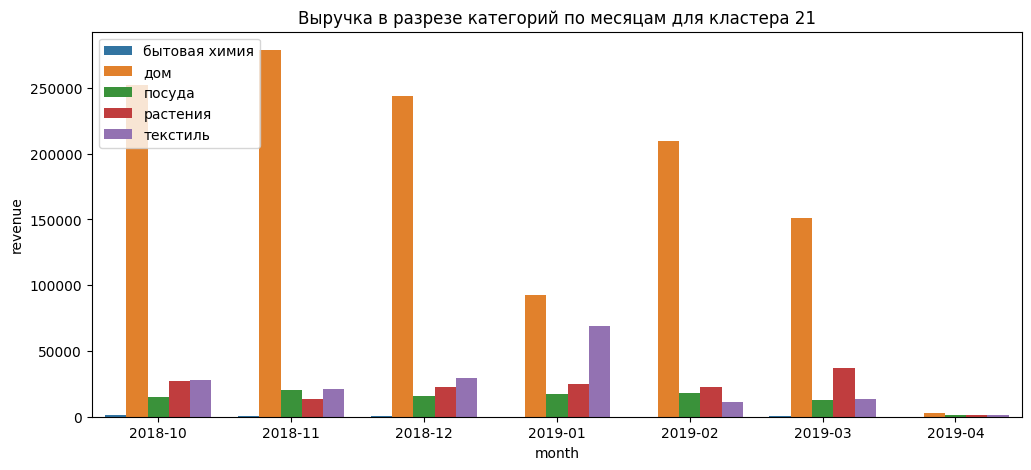

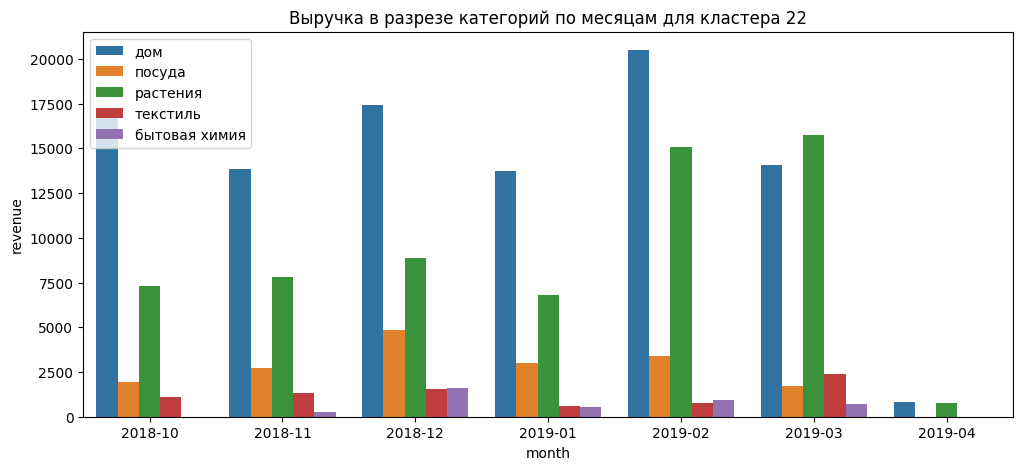

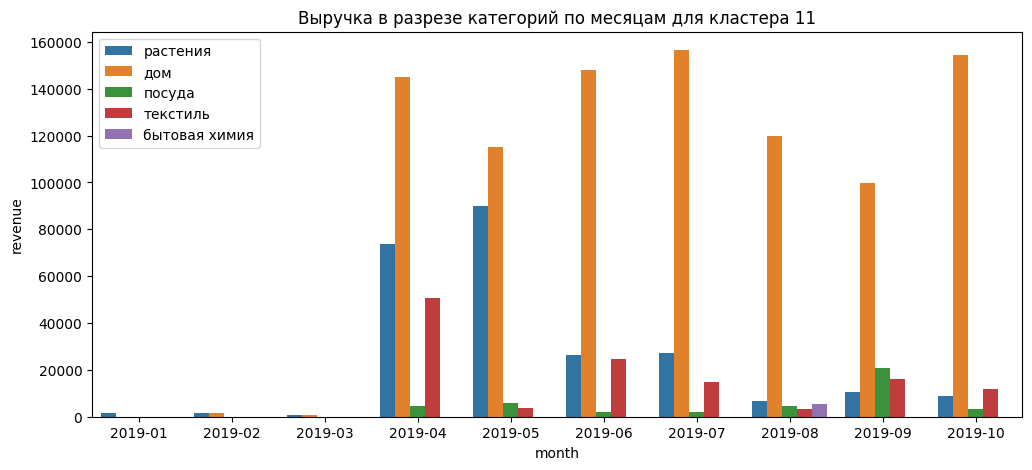

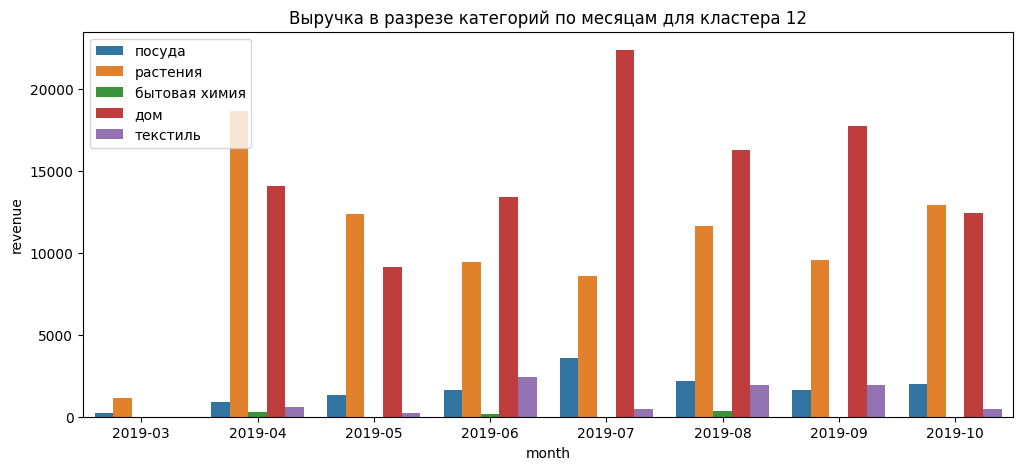

In [102]:
#Выводим сезонность объемов продаж для каждого кластера
for p in all_clasters_new:
    season_category_new(p)

Таким образом, для наших сегментов релевантны следующие рекомендации
- сегмент 11 - клиенты с недавними покупками и высоким средним чеком - товары категории "дом" - апрель, июнь, июль, октябрь; товары категории "растения" - апрель, май.
- сегмент 12 - клиенты с недавними покупками и низким средним чеком - товары категории "дом" - июль; товары категории "растения" - апрель.
- сегмент 21 - клиенты с давними покупками и высоким средним чеком - товары категории "дом" - с октября по декабрь и февраль
- сегмент 22 - клиенты с давними покупками и низким средним чеком - товары категории "дом" - декабрь и февраль, товары категории "растения" - февраль, март.

## Проверка статистических гипотез

У нас получилось 4 кластера. Будем сравнивать каждый кластер с каждым по критериям среднего чека и давности покупки.
Наши гипотезы по сравнению данных будут сформулированы так:
Н0 - между данными нет статистически значимых различий, Н1 - между данными есть статистически значимые различия.

Перед проверкой гипотез осуществим проверку данных на номальность с помощью теста Шапиро-Уилка: H0 - данные распределены нормально, Н1 - данные распределены не нормально.

### Средний чек

In [108]:
#Выделим средний чек разных групп пользователей в отдельные списки
table = df[['customer_id', 'mean_check', 'a', 'client_clasters_new']].drop_duplicates()
users_11_mc=table.query('client_clasters_new == "11"')['mean_check']
users_12_mc=table.query('client_clasters_new == "12"')['mean_check']
users_21_mc=table.query('client_clasters_new == "21"')['mean_check']
users_22_mc=table.query('client_clasters_new == "22"')['mean_check']

In [109]:
all_mc = [users_11_mc, users_12_mc, users_21_mc, users_22_mc]

In [110]:
#Функция проверки данных на нормальность распределения
def norm(mc):
    alpha = 0.05  
    results = st.shapiro(mc)
    p_value = results[1] 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    

In [111]:
for a in all_mc:
    norm(a)

p-значение:  7.625852229871011e-39
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.204594357038041e-16
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  5.841592908230865e-41
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.7924125007737152e-14
Отвергаем нулевую гипотезу: распределение не нормально


Данные распределены не нормально, размеры выборок у нас разные, ttest использовать нельзя. Делаем проверку гипотез через Манна-Уитни.

In [112]:
#Проверяем пары 11 и 12
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_mc, users_12_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  5.940848505999834e-197
Отвергаем нулевую гипотезу: разница статистически значима


In [113]:
#Проверяем пары 11 и 21
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_mc, users_21_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.8376290056646611
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [114]:
#Проверяем пары 11 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_mc, users_22_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  4.746380425736987e-184
Отвергаем нулевую гипотезу: разница статистически значима


In [115]:
#Проверяем пары 12 и 21
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_12_mc, users_21_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  5.598352389372753e-210
Отвергаем нулевую гипотезу: разница статистически значима


In [116]:
#Проверяем пары 12 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_12_mc, users_22_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.10124801858583105
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [117]:
#Проверяем пары 21 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_21_mc, users_22_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  2.319890564050015e-195
Отвергаем нулевую гипотезу: разница статистически значима


По критерию среднего чека есть статистическая разница между следующими парами кластеров: 11-12, 11-22, 12-21, 21-22. 
Статистической разницы нет при сравнении пар: 11-21, 12-22. Это логично - мы ведь сравниваем пары, сформированные по одному критерию среднего чека.

### Давность покупки

In [118]:
#Выделим давность последней покупки разных групп пользователей в отдельные списки
users_11_tp=table.query('client_clasters_new == "11"')['a']
users_12_tp=table.query('client_clasters_new == "12"')['a']
users_21_tp=table.query('client_clasters_new == "21"')['a']
users_22_tp=table.query('client_clasters_new == "22"')['a']

In [119]:
all_tp = [users_11_tp, users_12_tp, users_21_tp, users_22_tp]

In [120]:
for k in all_tp:
    norm(k)

p-значение:  1.1880438039596486e-13
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.690952183846164e-14
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  1.1603844851681457e-14
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.9000315603794347e-13
Отвергаем нулевую гипотезу: распределение не нормально


Данные распределены не нормально, размеры выборок у нас разные, ttest использовать нельзя. Делаем проверку гипотез через Манна-Уитни.

In [121]:
#Проверяем пары 11 и 12
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_tp, users_12_tp)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.04350438310181793
Отвергаем нулевую гипотезу: разница статистически значима


In [122]:
#Проверяем пары 11 и 21
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_tp, users_21_tp)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  1.2029746475895898e-196
Отвергаем нулевую гипотезу: разница статистически значима


In [123]:
#Проверяем пары 11 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_11_tp, users_22_tp)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  4.930834829645741e-184
Отвергаем нулевую гипотезу: разница статистически значима


In [124]:
#Проверяем пары 12 и 21
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_12_tp, users_21_tp)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  5.7905848092475904e-210
Отвергаем нулевую гипотезу: разница статистически значима


In [125]:
#Проверяем пары 12 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_12_tp, users_22_tp)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  1.2409455903572278e-195
Отвергаем нулевую гипотезу: разница статистически значима


In [126]:
#Проверяем пары 21 и 22
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(users_21_mc, users_22_mc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  2.319890564050015e-195
Отвергаем нулевую гипотезу: разница статистически значима


По критерию давности заказа есть статистическая разница между всеми парами кластеров.

## Вывод

С целью повышения товароооборота интернет-магазина "Пока все еще тут" был проведен анализ данных интернет-магазина за период с октября 2018 по октябрь 2019. Был выявлен ряд особенностей предоставленных данных, дана оценка текущему положению дел бизнеса, а также проведен анализ профилей пользователей - был применен RFM-анализ, выделены клиентские кластеры, выделены ключевые товарные категории и периоды для проведения целевых e-mail рассылок. 

Что хочется отметить относительно самих данных:
- выгрузка данных презентовалась как датасет по транзакцим. Соответственно в такой выгрузке логично должна была быть представлена информация об уникальном id-заказа и его общей сумме. Фактически в выгрузке каждая строка представляла собой товарную номенклатуру в заказе с количеством и ценой. Сомнительно, что каждый товар проходит отдельной транзакцией. Иными словами - датасет составлен не по транзакциям.
- сама выгрузка данных была довольно низкого качества, т.к. собиралась, во всей видимости, из разных источников. Низкое качество заключалось в том, что на одно и то же сочетание ID-клиента, ID-заказа, товара, цены и количества приходится несколько строк с разной датой и временем. То есть собранные из нескольких источников данные создали множество дубликатов. Для корректной работы с датасетом пришлось удалить поорядка 1/3 от исходных данных.
- еще один факт, подтверждающий плохое качество исходных данных - факт наличия нескольких заказчиков на один заказ. При таком положении дел вообще нельзя быть достоверно уверенными в тех выводах, которые можно сделать по такому исходнику. Рекомендация для собственника бизнеса качественнее вести лог действий, чтобы в дальнейшем избегать "шумов" и прочих аномалий в данных.
- исходные данные содержали выбросы (заказ на 1000 вантузов). Чисто практически врядли интернет-магазин содержит такие товарные остатки на одну номенклатуру. Вероятнее всего данный заказ вообще был аннулирован или позже возвращен. Что опять же вызывает вопросы к качеству исходно предоставленных данных.
- по невыясненным причинам в выгрузке отсутствуют данные о категориях товара. В случае, если товары на сайте действительно висят без привязке к категориям и нет удобного товарного каталога, не удивительно, что бизнес "выезжает" только на разовых покупках - клиенты просто не могут ничего найти на сайте при повторных посещениях.

В отношении текущего положения бизнеса хочется отметить:
- выручка в октябре 2019 упала почти на 50% по отношению к выручке октября 2018. Звонок довольно тревожный, поэтому необходимо предпринимать действия для реанимации бизнеса пока еще не поздно. В целом по тренду видно, что ежемесячно объемы выручки падают.
- что касается количества заказов в интернет-магазине явно выражен тренд на клиентскую активность в апеле и мае - в эти месяцы количество заказов бьет рекорды. Однако всплесков по выручке в эти периоды не наблюдается, что говорит о том, что клиенты заказывают много дешевого товара.
- При оценке среднего чека также заметен сезонный фактор - дорогие заказы в декабре и январе - их мало, но они генерят максимальные значения по выручке. И дешевые заказы в апреле-мае, генерируют сопоставимую со среднегодовой выручку, но за счет большого количества самих заказов роняют средний чек. Если исключить два сезонных периода, видно, что в целом средний чек находится примерно на одном уровне - около 850 руб.
- Конверсия в повторную покупку составила около 10%. Иными словами 90% клиентов не вернулись за повторными покупками в течение года. Это говорит о том, что "теплую" уже совершившую первый заказ аудиторию, никто далее не прорабатывает, бизнес теряет деньги. Около 6% клиентов покупают раз в 1-2 месяца. Клиенты с более частыми покупками - скорее единичные аномалии.
- Количество пользовавтелей, сделавших последний заказ в последние 3 месяца примерно равно количеству пользователей, сделавших последний заказ более 9 месяцев назад от конца выгрузки. Обе эти категории составляют 50% от всего количества пользователей. Остальные 50% относятся к "спящим" пользователям - они сделали последний заказ в интервале между 3-мя и 9-ю месяцами по отношению к концу выгрузки.
- средний чек колеблется в диапазоне от 14 до 49 432 руб. за заказ. 25% покупателей за исследуемый период сделали заказы со средним чеком до 298 руб. 75% покупателей уложились в 1471 руб. в среднем за заказ.
- Почти 70% выручки приходится на категорию товаров для дома и хозтоваров.
- Сезонность спроса: категория с максимальным оборотом - товары для дома - пользуется максимальным спросом в конце года - с октября по декабрь, а также в феврале. Вторая по размерам оборота категория - растения - демонстрирует логичную сезонность в весенние месяцы. Следующей по выручке является категория домашнего текстиля - максимльные размеры выручки заметны в январе и апреле - для того, чтобы сделать вывод о сезонности по этой категории необходимо изучить больший промежуток времени в выгрузке данных. Соответственно данный фактор необходимо учитывать при планировании товарных запасов, чтобы удовлетворять покупательский спрос; а также в преддверии высокого сезона той или иной товарой категории необходимо приземлять внимание покупателей на сайт путем тех же товарных рассылок.


**Характеристики выделенных кластеров и рекомендации по рассылке**

В ходе исследования были выделены 4 кластера: 
- первый - клиенты, совершившие покупки за последние 7 месяцев и средним чеком выше 676 руб. Доля таких клиентов в клиентском массиве - 23,5%. Структура выручки внутри данного кластера по товарным категориям: 70% - "дом", 18% - "растения", 9% - "текстиль". Средний чек покупки составляет 2151 руб. Максимальная выручка внутри кластера наблюдается в месяцах: апрель, июнь, июль, октябрь - для категори "дом" - на уровне 150 тыс. руб. в мес.; а также в месяцах: апрель и май - для категории "растения" - на уровне 85 тыс. руб. в мес.
- второй - клиенты, совершившие покупки за последние 7 месяцев и средним чеком ниже 676 руб. Доля таких клиентов в клиентском массиве 26,7%. Структура выручки внутри данного кластера по товарным категориям: 49,7% - "дом", 39,7% - "растения", 6,4% - "посуда". Средний чек покупки составляет 305,5 руб. Максимальная выручка внутри кластера наблюдается в июле - для категори "дом" - на уровне 23 тыс. руб. в мес.; а также в апреле для категории "растения" - на уровне 18 тыс. руб. в мес.
- третий - клиенты, совершавшие покупки более 7 мес. назад со средним чеком более 676 руб. Длдя таких клиентов в клиентском массиве - 26,6%. Структура выручки внутри данного кластера по товарным категориям: 74,4% - "дом", 10,4% - "тектиль", 9% - "растения". Средний чек покупки составляет 2158 руб. Максимальная выручка внутри кластера наблюдается в с октября по декабрь - для категори "дом" - на уровне 250 тыс. руб. в мес.
- четвертый - клиенты, совершавшие покупки более 7 мес. назад и средним чеком менее 676 руб. Доля таких клиентов в клиентском массиве - 23,2%. Структура выручки внутри данного кластера по товарным категориям: 51,5% - "дом", 33% - "растения", 9,3% - "посуда". Средний чек покупки составляет 322 руб. Максимальная выручка внутри кластера наблюдается фервале - для категори "дом" - на уровне 20 тыс. руб. в мес.; а также в месяцах: февраль и март - для категории "растения" - на уровне 20 тыс. руб. в мес.

С точки зрения максимизации выручки наибольший интерес представляют первый и третий кластеры по причине потенциальной выручки, которую могут принести при повторных покупках на сайте. Соответственно настраивать рассылки стоит только на них, не беря в расчет второй и четвертый кластеры. Также заметно, что среди первого и третьего кластера самая популярная и емкая товарная категория - товары для дома, соответственно товары именно этой категории необходимо включать в рассылку.

Ссылка на презентацию: https://disk.yandex.ru/i/QVxt5KDBgsWcEA